# <center> Тестовое задание для стажировки

В данной тетрадке я буду решать (если честно, перерешивать, используя методы и навыки, обретенные мной в процессе учебной практики) задачу из [соревнования на Kaggle](https://www.kaggle.com/competitions/motorica-skillfactory-internship-test-task-2023-12/overview), которое было организовано Skillfactory и Моторикой для желающих пройти на учебную стажировку. Сама задача заключается в классификации непрерывных команд от пользователя на основе данных, полученных от оптомиографических датчиков.

Необходимо построить модель распознавания жестов в парадигме обучения с учителем. Параметры модели должны быть оптимизированы на предложенных данных для обучения. Валидация модели должна произведиться на отложенной тестовой выборке на платформе соревнования.

## Загрузка и преобразование данных

Сперва подгрузим инструментарий

In [1]:
# Для работы с числами и таблицами
import numpy as np
import pandas as pd

# Для визуализации
import matplotlib.pyplot as plt
plt.style.use('bmh')

# Для работы с данными
from sklearn import decomposition
from sklearn import model_selection
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn import inspection
from sklearn import metrics

# Алгоритмы МО
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import svm
from sklearn import neighbors
from sklearn import neural_network
from sklearn import tree
from sklearn import ensemble

# Оконная функция для обработки данных
from scipy import signal

# Еще три алгоритма ГБ
import xgboost as xgb
import lightgbm as lgbm
import catboost as cb

# Оптимизации моделей
import optuna

# Архивация
import joblib

# Контроль предупреждений
import warnings

# Progress bar
from tqdm import tqdm

Данные

In [2]:
# факторы
X = np.load('data/data_kaggle/X_train.npy')
X_test = np.load('data/data_kaggle/X_test.npy')

# целевые переменные
Y = pd.read_csv('data/data_kaggle/y_train.csv')
y_test = pd.read_csv('data/data_kaggle/sample_submission.csv')

print(X.shape, Y.shape)
print(X_test.shape, y_test.shape)

(323, 40, 100) (32300, 2)
(54, 40, 100) (5400, 2)


Как видим, они упакованы в 3D-массивы. Для дальнейшей работы нам необходимо их развернуть.

In [3]:
X_2d = np.zeros((0, 40))
X_test_2d = np.zeros((0, 40))

for i in range(X.shape[0]):
    X_2d = np.vstack((X_2d, X[i].T))
    
for i in range(X_test.shape[0]):
    X_test_2d = np.vstack((X_test_2d, X_test[i].T))  

    
X_2d.shape, X_test_2d.shape

((32300, 40), (5400, 40))

Сформируем из получившихся данных соответствующие датафреймы.

In [4]:
X_2d_df = pd.DataFrame(X_2d)
X_2d_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,1123.0,10.0,1450.0,64.0,34.0,1743.0,145.0,12.0,1068.0,14.0,...,1877.0,73.0,13.0,1169.0,129.0,29.0,1677.0,36.0,718.0,26.0
1,1125.0,7.0,1441.0,66.0,33.0,1738.0,143.0,17.0,1064.0,0.0,...,1876.0,70.0,20.0,1170.0,132.0,28.0,1673.0,28.0,730.0,25.0
2,1121.0,17.0,1444.0,60.0,32.0,1732.0,141.0,10.0,1065.0,14.0,...,1878.0,77.0,14.0,1169.0,130.0,30.0,1670.0,29.0,727.0,27.0


In [5]:
X_test_2d_df = pd.DataFrame(X_test_2d)
X_test_2d_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,1681.0,4.0,1834.0,33.0,26.0,2254.0,43.0,0.0,1376.0,27.0,...,1635.0,82.0,16.0,1204.0,108.0,25.0,1685.0,27.0,386.0,25.0
1,1679.0,17.0,1826.0,36.0,26.0,2250.0,43.0,5.0,1369.0,28.0,...,1643.0,71.0,19.0,1186.0,108.0,26.0,1689.0,25.0,388.0,27.0
2,1673.0,4.0,1827.0,35.0,25.0,2251.0,42.0,10.0,1371.0,19.0,...,1658.0,72.0,15.0,1204.0,106.0,25.0,1690.0,32.0,388.0,27.0


Посмотрим, есть ли пропущенные данные. Специфика сбора данных не предполагает пропусков, иначе это могло бы говорить о неисправностях соответствующего оборудования, способных внести искажения в большую часть записи движений оператора. Но мы все же проверим:

In [6]:
print(f'Число пропусков в train-сете: {X_2d_df.isna().sum().sum()}')
print(f'Число пропусков в test-сете:  {X_test_2d_df.isna().sum().sum()}')

Число пропусков в train-сете: 0
Число пропусков в test-сете:  0


Оценим соотношение классов в `y_train`.

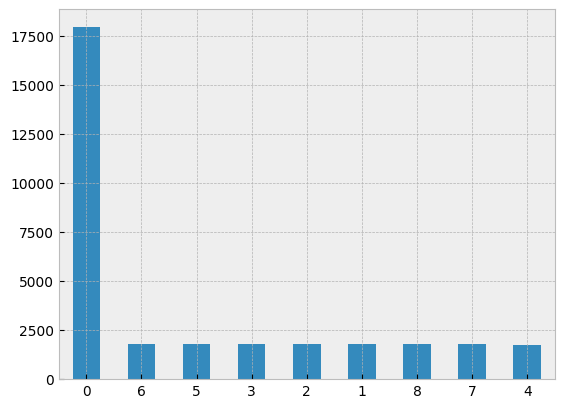

In [7]:
Y_2d = Y['class']

Y_2d.value_counts().plot(kind="bar", rot=0.5);

Y_2d = Y_2d.values

Класс `0`, как видим, представлен в данных на порядок чаще.

`y_train.csv` содержит следующие классы:
  - `0` - команда "Open";
  - `1` - команда "сгиб мизинца";
  - `2` - команда "сгиб безымянного пальца";
  - `3` - команда "сгиб среднего пальца";
  - `4` - команда "жест пистолет";
  - `5` - команда "сгиб указательного пальца";
  - `6` - команда "сгиб большога пальца";
  - `7` - команда "жест ОК";
  - `8` - команда "жест grab";¶

### Исходный вид

Восстановим исходный вид меток для корректной визуализации логирования показаний датчиков. Также для сабмита в Kaggle предсказаний модели необходимо будет повторить этот код.

In [8]:
y_train_original = Y.copy()

y_train_original[['sample_id', 'timestep']] = y_train_original['sample-timestep'].str.split(pat="-", n=1, expand=True).astype(int)
y_train_original = y_train_original.pivot(index='sample_id', columns='timestep', values='class')
Y_index = Y.index
y_train_original = y_train_original.sort_index() # на всякий случай
y_train_original = y_train_original.values

print(y_train_original.shape)
y_train_original

(323, 100)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 6, 6, 6],
       ...,
       [0, 0, 0, ..., 7, 7, 7],
       [7, 7, 7, ..., 0, 0, 0],
       [0, 0, 0, ..., 4, 4, 4]], dtype=int64)

Код для просмотра состояния данных в *странице* был предоставлен организаторами соревнования в бейзлайне.

В исходных данных насчитывается 323 *страницы*, каждая из которых включает в себя наблюдение длительностью в течении ста некоторых единиц времени. Мы можем визуализировать пару из показаний датчиков и классов исполняемых команд на произвольной странице.

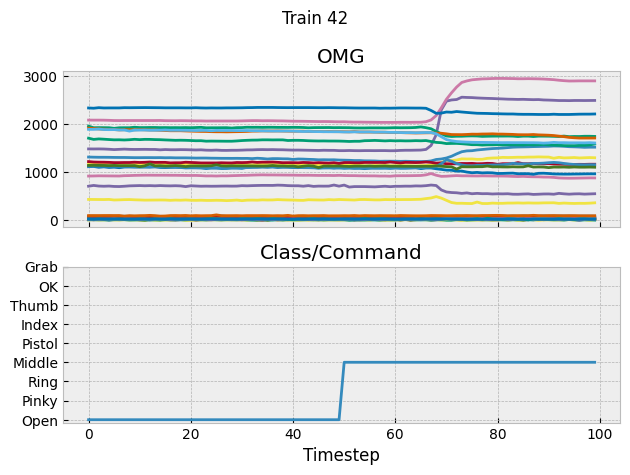

In [9]:
# Номер страницы в 3d-массиве
i = 42
# Объявим лейблы жестов
GESTURES = ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']

fig, axx = plt.subplots(2, 1, sharex=True)
axx[0].plot(X[i].T)
axx[0].set_title('OMG')
axx[1].plot(y_train_original[i])
axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(np.arange(9), GESTURES)
plt.suptitle(f'Train {i}')
plt.tight_layout()

Первая странность, которую можно обнаружить на многих *страницах*: опережающее изменение класса.

Мы можем визуализировать данные в развернутом виде — общая панормама.

In [10]:
# Функция для отрисовки графики "OMG and Protocol" для заданного интервала
def get_graphs(X_array, y_array, start=1000, end=1500):
    
    _, ax1 = plt.subplots(sharex=True, figsize=(12, 4))
    plt.suptitle(f'OMG and Protocol {start}:{end}')
    ax1.plot(X_array[start:end])
    ax1.set_xlabel('Timesteps')
    ax1.set_ylabel('OMG')
    plt.grid(axis='y')
    ax2 = ax1.twinx()
    ax2.plot(y_array[start:end], 'b-')
    ax2.set_ylabel('y_cmd')
    plt.yticks(np.arange(len(GESTURES)), GESTURES)
    plt.show()

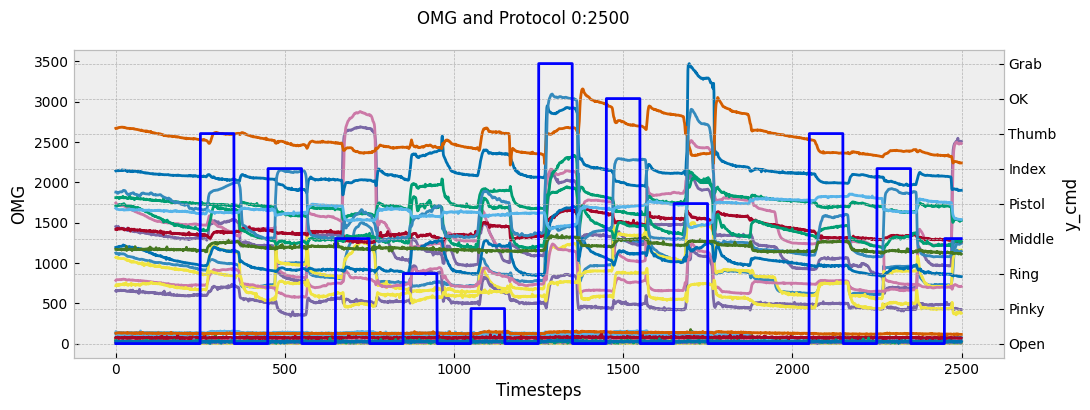

In [11]:
get_graphs(X_2d, Y_2d, start=0, end=2500)

Т.к. таргет представляет собой запротоколированные команды на выполнение жестов, а данные с датчиков получаются при исполнении их оператором, мы можем наблюдать некоторое запаздывание данных, их смещение вправо относительно таргета.

Существуют разные мнения о том, как стоит отнестись к этому моменту: смещать ли таргет вправо или оставить как есть. Наша задача — обучить модель распознавать жесты по сигналам с датчиков. Следовательно, имеет смысл помочь модели отслеживать моменты изменения в данных, свидетельствующие о начале исполнения жеста. Если оставить данные как есть, то сигналы, выходящие за рамки прямоугольников таргета на изображении выше, могут, вероятно, внести вклад в ошибку модели.

Другую позицию озвучил один из организаторов конкурса (специалист из Моторики): сильное смещение таргета может вызвать утечку данных о целевом признаке. Стоит отметить, что обучить достаточно качественную модель можно и без смещения: победители конкурса этого не сделали, однако смогли получить значения метрики F1 выше 0,95.

Ну, а в этой работе таргет все же будет смещен.

---
---
## Препроцессинг

### Устранение лага между сигналами датчиков и таргетом

In [12]:
def get_naive_centering(X_arr, y_arr, gap=500, inter=1000, window=30, use_m=True, model=svm.SVC()):
    """Функция для устранения глобального лага между сигналами датчиков и таргетом.

    Args:
        X_arr (ndarray): Массив данных.
        y_arr (ndarray): Вектор целевого признака.
        gap (int, optional): Размеры концевых отступов. Defaults to 500.
        inter (int, optional): Величина концевых выборок. Defaults to 1000.
        window (int, optional): Величина окна поиска оптимального сдвига. Defaults to 20.
        use_m (bool, optional): Использование модели для поиска оптимального сдвига.
            Defaults to True. False: поиск сдвига по корреляции таргета с вектором
            суммы модулей дифференциалов векторов признаков массива данных.
        model (abc.ABCMeta, optional): Алгоритм scikit-learn. Defaults to svm.SVC().

    Returns:
        tuple():
            ndarray: Вектор сдвинутого таргета.
            list: Строки отчета по проделанным операциям.
    """
    # part of the data from the beginning
    X_part1 = X_arr[gap:gap+inter]
    y_part1 = y_arr[gap:gap+inter]
    # part of the data from the end
    X_part2 = X_arr[-gap-inter:-gap]
    y_part2 = y_arr[-gap-inter:-gap]
    
    def get_diff(X):
        return pd.DataFrame(X).diff().abs().sum(axis=1)
        # return np.sum(np.abs(np.diff(X)), axis=1)
    
    # Функция для сдвига таргета
    def shifter(y_arr, shift=1):
        first_element = y_arr[0]
        prefix = np.full(shift, first_element)
        y_arr_shifted = np.concatenate((prefix, y_arr))[:-shift]
    
        return y_arr_shifted
    
    # Функция для расчета точности модели
    def get_score(X, y, model=model):
        X = get_diff(X).values.reshape(-1, 1)
        model = model
        model.fit(X, y)
        preds = model.predict(X)
        
        return metrics.accuracy_score(y, preds)
    
    # Функция для расчета корреляции
    def get_corr(X, y):
        x_diff = get_diff(X)
        correlation = np.corrcoef(x_diff, y)[0, 1]
        
        return abs(correlation)
    
    
    max_score1, current_score1 = 0, 0
    max_score2, current_score2 = 0, 0
    s1, s2 = 1, 1
    
    for i in range(1, window+1):
        y_a = shifter(y_part1, shift=i)
        y_b = shifter(y_part2, shift=i)
        
        if use_m:
            current_score1 = get_score(X_part1, y_a)
            current_score2 = get_score(X_part2, y_b)
        else:
            current_score1 = get_corr(X_part1, y_a)
            current_score2 = get_corr(X_part2, y_b)
        
        if current_score1 > max_score1:
            max_score1, current_score1 = current_score1, max_score1
            s1 = i
        
        if current_score2 > max_score2:
            max_score2, current_score2 = current_score2, max_score2
            s2 = i
    
    optimal_shift = round((s1+s2)/2)
    y_arr_shifted = shifter(y_arr, shift=optimal_shift)
    summary = [
        f'Оптимальные свдиги для концевых выборок:   {s1} и {s2}\n',
        f'Accuracy/correlation на концевых выборках: {max_score1}; {max_score2}\n',
        f'Размер оптимального сдвига (как среднего): {optimal_shift}'
    ]
    
    return y_arr_shifted, summary

In [13]:
# Выберем алгоритм для поиска смещения
fitting_model = svm.LinearSVC(dual='auto') # м/б использовано, если use_m=True
y_shifted, summary = get_naive_centering(X_2d, Y_2d, use_m=False, window=30, model=fitting_model)

print('Test sample shifting\n', *summary, sep='')

Test sample shifting
Оптимальные свдиги для концевых выборок:   19 и 18
Accuracy/correlation на концевых выборках: 0.2098838604340627; 0.05427119189935997
Размер оптимального сдвига (как среднего): 18


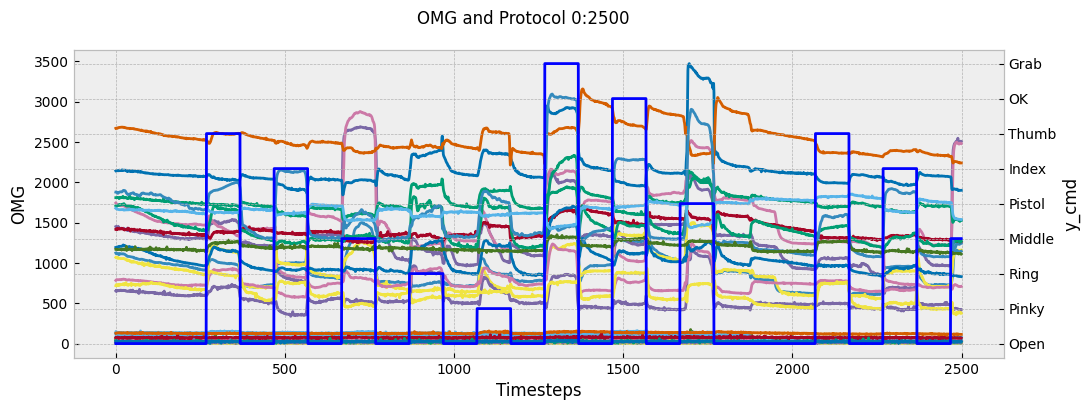

In [14]:
get_graphs(X_2d, y_shifted, start=0, end=2500)

Удалось скорректировать данные относительно таргета.

### Сэмплирование

Рассчитаем размер валидационной выборки

In [15]:
print(f'20% от X: {int(X_2d.shape[0] * 0.2)}')

20% от X: 6460


Уточним место разделения: оно должно производиться точно между сериями из восьми жестов.

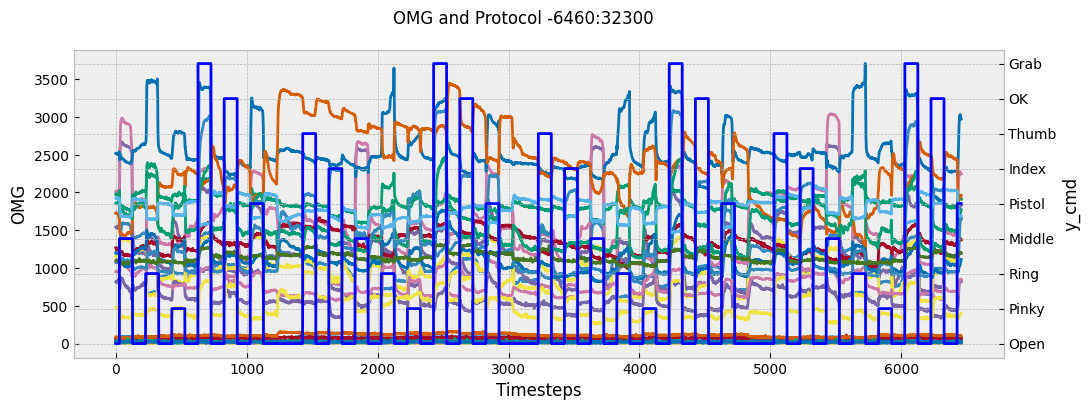

In [16]:
get_graphs(X_2d, y_shifted, start=-6460, end=X_2d.shape[0])

Попробуем взять левее, чтобы полностью ухватить еще один жест Thumb.

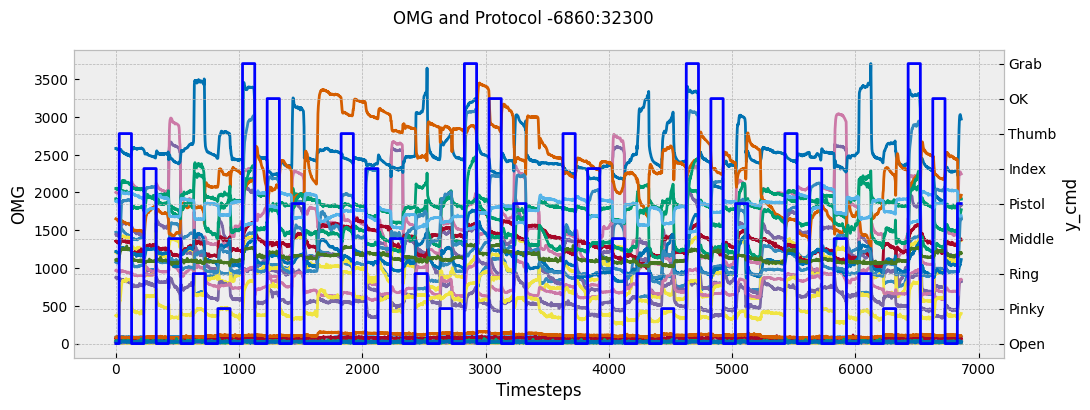

In [17]:
get_graphs(X_2d, y_shifted, start=-6860, end=X_2d.shape[0])

Этого хватит. Таким образом, последний индекс трейн-выборки:

In [18]:
last_train_idx = X_2d.shape[0] - 6860
last_train_idx

25440

И, наконец, сэмплируем.

In [19]:
X_train_2d = X_2d[:last_train_idx]
X_valid_2d = X_2d[last_train_idx:]

y_train_2d = y_shifted[:last_train_idx]
y_valid_2d = y_shifted[last_train_idx:]

print(X_train_2d.shape, y_train_2d.shape)
print(X_valid_2d.shape, y_valid_2d.shape)

(25440, 40) (25440,)
(6860, 40) (6860,)


Если мы желаем построить непредвзятое исследование влияния различных методов предобработки, генерации и отбора признаков на предсказательную силу моделей, необходимо организовать некоторый способ хранения экземпляров данных, прошедших предобработку, экземпляров сгенерированных признаков, а также экземпляров комбинаций первых со вторыми и т.д. Затем мы могли бы с помощью грубого перебора установить — на каких типах данных какие типы алгоритмов МО показывают наилучший результат.

С этой целью мы создадим словарь сэмплов, в котором будем хранить экземпляры данных. Чтобы сократить время грубого перебора, в ходе которого будут обучаться отобранные нами алгоритмы, мы будем отбирать лишь части треннировочной и валидационной выборок — экземпляры. Однако сперва нужно определиться с их размерами для каждой выборки. Важно ухватить целое число жестов каждого вида, важно также обеспечить равное представительство восьми жестов (если считать без open-жеста) в экземплярах каждой выборки.

Первыми будут экземпляры исходных данных. Словарь сэмплов должен содержать экземпляры с одинаковым числом строк. Чтобы определить приемлемые размеры, мы снова посмортим на графику.

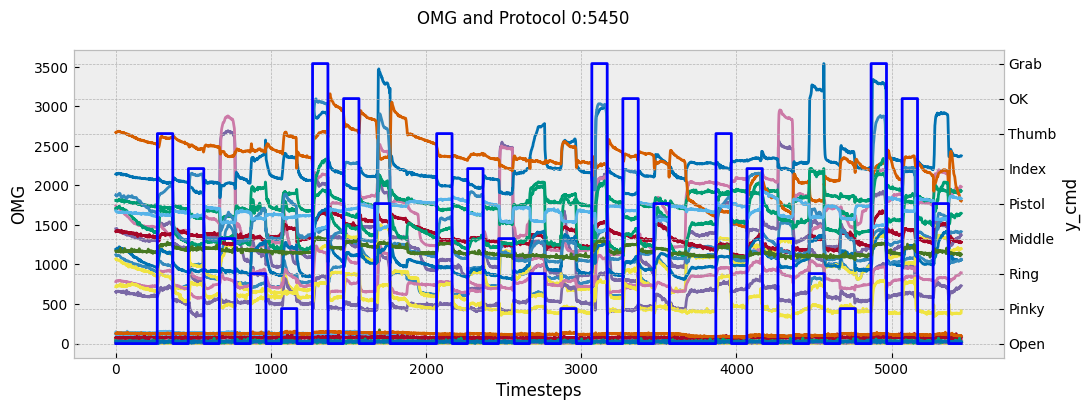

In [20]:
get_graphs(X_train_2d, y_train_2d, start=0, end=5450)

Пожалуй, 5450 строк для трейн-экземпляров будет достаточно. Определимся с размером валидационных.

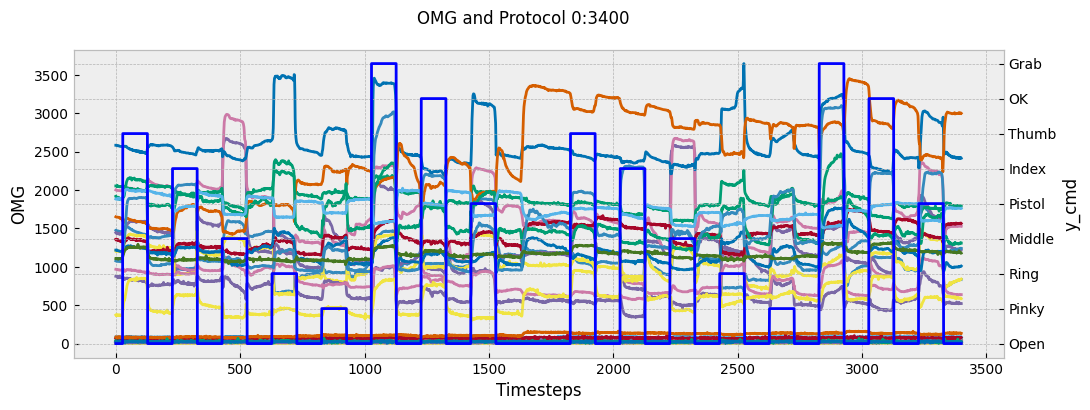

In [21]:
get_graphs(X_valid_2d, y_valid_2d, start=0, end=3400)

Итак, с размерами определились, сохраним теперь первую пару сэмплов в нашем словаре.

In [22]:
train_ss = 5450 # train sample size
valid_ss = 3400 # valid sample size

# Словарь сэмплов
samples_dict = {}
samples_dict['samples_0'] = [X_train_2d[:train_ss], X_valid_2d[:valid_ss]]

### Нормализация и стандартизация

In [23]:
mm_scaler = preprocessing.MinMaxScaler()
X_train_mm = mm_scaler.fit_transform(X_train_2d)
X_valid_mm = mm_scaler.transform(X_valid_2d)
X_test_mm = mm_scaler.transform(X_test_2d)

normalizer = preprocessing.Normalizer()
X_train_norm = normalizer.fit_transform(X_train_2d)
X_valid_norm = normalizer.transform(X_valid_2d)
X_test_norm = normalizer.transform(X_test_2d)

rb_scaler = preprocessing.RobustScaler()
X_train_rb = rb_scaler.fit_transform(X_train_2d)
X_valid_rb = rb_scaler.transform(X_valid_2d)
X_test_rb = rb_scaler.transform(X_test_2d)

st_scaler = preprocessing.StandardScaler()
X_train_st = st_scaler.fit_transform(X_train_2d)
X_valid_st = st_scaler.transform(X_valid_2d)
X_test_st = st_scaler.transform(X_test_2d)

А теперь соберем экземпляры.

In [24]:
samples_dict['samples_mm'] = [X_train_mm[:train_ss], X_valid_mm[:valid_ss]]
samples_dict['samples_norm'] = [X_train_norm[:train_ss], X_valid_norm[:valid_ss]]
samples_dict['samples_rb'] = [X_train_rb[:train_ss], X_valid_rb[:valid_ss]]
samples_dict['samples_st'] = [X_train_st[:train_ss], X_valid_st[:valid_ss]]

### Генерация признаков
#### Аппроксимирующая модель линейной регрессии

In [25]:
def get_approx_lr_coefs(X, n_ftrs=10, prev=None, lin_alg=None):
    """Функция для формирования признакового описания 
       с использованием линейной регрессии

    Args:
        X (ndarray): массив данных.
        n_ftrs (int, optional): размер сэмпла. Defaults to 10.
        prev (ndarray, optional): предшествующие данные размером n_ftrs.
        Defaults to None.
        lin_alg (abc.ABCMeta, optional): линейный алгоритм sklearn.
        По умолчанию используется алгоритм МНК из numpy.

    Returns:
        ndarray: массив коэффициентов модели регрессии.
    """
    
    def get_coefs(data):
        # Разделение данных на признаки и целевую переменную
        segments_X = data[1:, :].T
        segments_y = data[0, :]
        
        # Обучение модели линейной регрессии
        if lin_alg is not None:
            model = lin_alg()
            model.fit(segments_X, segments_y)
            # Получение параметров модели
            return model.coef_
        else:
            w = np.linalg.lstsq(segments_X, segments_y, rcond=None)[0]
            # Вектор весов линейной функции
            return w
        
    
    w_g = np.zeros((0, n_ftrs))
    window = np.zeros((n_ftrs+1, X.shape[-1]))
    if prev is not None:
        window[1:, :] = prev
    
    for i in range(X.shape[0]):
        if not np.sum(window[0]):
            window[0, :] = X[i]
        else:
            window[1:, :] = window[:-1, :]
            window[0, :] = X[i]

        coefs = get_coefs(window)
        w_g = np.vstack((w_g, coefs))
    
    return w_g

Сгенерируем новые сэмплы.

In [26]:
X_train_ax = get_approx_lr_coefs(X_train_2d)
X_valid_ax = get_approx_lr_coefs(X_valid_2d)
X_test_ax = get_approx_lr_coefs(X_test_2d)
samples_dict['samples_ax'] = [X_train_ax[:train_ss], X_valid_ax[:valid_ss]]

X_train_mm_ax = get_approx_lr_coefs(X_train_mm)
X_valid_mm_ax = get_approx_lr_coefs(X_valid_mm)
X_test_mm_ax = get_approx_lr_coefs(X_test_mm)
samples_dict['samples_mm_ax'] = [X_train_mm_ax[:train_ss], X_valid_mm_ax[:valid_ss]]

X_train_norm_ax = get_approx_lr_coefs(X_train_norm)
X_valid_norm_ax = get_approx_lr_coefs(X_valid_norm)
X_test_norm_ax = get_approx_lr_coefs(X_test_norm)
samples_dict['samples_norm_ax'] = [X_train_norm_ax[:train_ss], X_valid_norm_ax[:valid_ss]]

X_train_rb_ax = get_approx_lr_coefs(X_train_rb)
X_valid_rb_ax = get_approx_lr_coefs(X_valid_rb)
X_test_rb_ax = get_approx_lr_coefs(X_test_rb)
samples_dict['samples_rb_ax'] = [X_train_rb_ax[:train_ss], X_valid_rb_ax[:valid_ss]]

X_train_st_ax = get_approx_lr_coefs(X_train_st)
X_valid_st_ax = get_approx_lr_coefs(X_valid_st)
X_test_st_ax = get_approx_lr_coefs(X_test_st)
samples_dict['samples_st_ax'] = [X_train_st_ax[:train_ss], X_valid_st_ax[:valid_ss]]

#### Аппроксимирующая модель авторегрессии

In [27]:
def get_ar_coefs(array, p=5, prev=None):
    """Функция для генерации новых признаков на основе векторов
    оптимальных параметров модели авторегрессии.

    Args:
        array (ndarray): массив данных.
        p (int, optional): размер базы аппроксимации. Defaults to 5.
        prev (ndarray): массив данных для аппроксимации первой точки.
        Defaults to None.

    Returns:
        ndarray: массив сгенерированных признаков на основе
        рассчитанных коэффициентов.
    """
    new_features = np.zeros((array.shape[0],0))
    
    # Проходим внешним циклом по переменным (столбцам) в данных
    for i in range(array.shape[1]):
        if prev is None:
            data = np.hstack((np.zeros(p), array[:, i]))
        else:
            data = np.hstack((prev[:, i], array[:, i]))
        t = len(data)
        w_massive = np.zeros((0, p+1))
        
        # Проходим внутренним циклом по вектору значений переменного
        for j in range(p, t):
            features = data[j-p:j]
            labels = np.array(data[j]).reshape(-1, 1)
        
            # Решение системы уравнений методом наименьших квадратов
            X = np.hstack((np.ones(1), features)).reshape(1, -1)
            w = np.linalg.lstsq(X, labels, rcond=None)[0]
            
            w_massive = np.vstack((w_massive, w.reshape(1, -1)))
            
        # Собираем в единый массив параметры МНК
        new_features = np.hstack((new_features, w_massive))
        
    return new_features

In [28]:
X_train_ar = get_ar_coefs(X_train_2d)
X_valid_ar = get_ar_coefs(X_valid_2d)
X_test_ar = get_ar_coefs(X_test_2d)
samples_dict['samples_ar'] = [X_train_ar[:train_ss], X_valid_ar[:valid_ss]]

X_train_mm_ar = get_ar_coefs(X_train_mm)
X_valid_mm_ar = get_ar_coefs(X_valid_mm)
X_test_mm_ar = get_ar_coefs(X_test_mm)
samples_dict['samples_mm_ar'] = [X_train_mm_ar[:train_ss], X_valid_mm_ar[:valid_ss]]

X_train_norm_ar = get_ar_coefs(X_train_norm)
X_valid_norm_ar = get_ar_coefs(X_valid_norm)
X_test_norm_ar = get_ar_coefs(X_test_norm)
samples_dict['samples_norm_ar'] = [X_train_norm_ar[:train_ss], X_valid_norm_ar[:valid_ss]]

X_train_rb_ar = get_ar_coefs(X_train_rb)
X_valid_rb_ar = get_ar_coefs(X_valid_rb)
X_test_rb_ar = get_ar_coefs(X_test_rb)
samples_dict['samples_rb_ar'] = [X_train_rb_ar[:train_ss], X_valid_rb_ar[:valid_ss]]

X_train_st_ar = get_ar_coefs(X_train_st)
X_valid_st_ar = get_ar_coefs(X_valid_st)
X_test_st_ar = get_ar_coefs(X_test_st)
samples_dict['samples_st_ar'] = [X_train_st_ar[:train_ss], X_valid_st_ar[:valid_ss]]

### Комбинирование

In [29]:
X_train_ax_ar = np.hstack((X_train_ax, X_train_ar))
X_valid_ax_ar = np.hstack((X_valid_ax, X_valid_ar))
X_test_ax_ar = np.hstack((X_test_ax, X_test_ar))
samples_dict['samples_ax_ar'] = [X_train_ax_ar[:train_ss], X_valid_ax_ar[:valid_ss]]

#------------------------------------------------

X_train_mm_ax_ar = np.hstack((X_train_mm_ax, X_train_mm_ar))
X_valid_mm_ax_ar = np.hstack((X_valid_mm_ax, X_valid_mm_ar))
X_test_mm_ax_ar = np.hstack((X_test_mm_ax, X_test_mm_ar))
samples_dict['samples_mm_ax_ar'] = [X_train_mm_ax_ar[:train_ss], X_valid_mm_ax_ar[:valid_ss]]

#------------------------------------------------

X_train_norm_ax_ar = np.hstack((X_train_norm_ax, X_train_norm_ar))
X_valid_norm_ax_ar = np.hstack((X_valid_norm_ax, X_valid_norm_ar))
X_test_norm_ax_ar = np.hstack((X_test_norm_ax, X_test_norm_ar))
samples_dict['samples_norm_ax_ar'] = [X_train_norm_ax_ar[:train_ss], X_valid_norm_ax_ar[:valid_ss]]

#------------------------------------------------

X_train_rb_ax_ar = np.hstack((X_train_rb_ax, X_train_rb_ar))
X_valid_rb_ax_ar = np.hstack((X_valid_rb_ax, X_valid_rb_ar))
X_test_rb_ax_ar = np.hstack((X_test_rb_ax, X_test_rb_ar))
samples_dict['samples_rb_ax_ar'] = [X_train_rb_ax_ar[:train_ss], X_valid_rb_ax_ar[:valid_ss]]

#------------------------------------------------

X_train_st_ax_ar = np.hstack((X_train_st_ax, X_train_st_ar))
X_valid_st_ax_ar = np.hstack((X_valid_st_ax, X_valid_st_ar))
X_test_st_ax_ar = np.hstack((X_test_st_ax, X_test_st_ar))
samples_dict['samples_st_ax_ar'] = [X_train_st_ax_ar[:train_ss], X_valid_st_ax_ar[:valid_ss]]

#------------------------------------------------

X_train_ax_ = np.hstack((X_train_2d, X_train_ax))
X_valid_ax_ = np.hstack((X_valid_2d, X_valid_ax))
X_test_ax_ = np.hstack((X_test_2d, X_test_ax))
samples_dict['samples_ax_'] = [X_train_ax_[:train_ss], X_valid_ax_[:valid_ss]]

#------------------------------------------------

X_train_mm_ax_ = np.hstack((X_train_mm, X_train_mm_ax))
X_valid_mm_ax_ = np.hstack((X_valid_mm, X_valid_mm_ax))
X_test_mm_ax_ = np.hstack((X_test_mm, X_test_mm_ax))
samples_dict['samples_mm_ax_'] = [X_train_mm_ax_[:train_ss], X_valid_mm_ax_[:valid_ss]]

#------------------------------------------------

X_train_norm_ax_ = np.hstack((X_train_norm, X_train_norm_ax))
X_valid_norm_ax_ = np.hstack((X_valid_norm, X_valid_norm_ax))
X_test_norm_ax_ = np.hstack((X_test_norm, X_test_norm_ax))
samples_dict['samples_norm_ax_'] = [X_train_norm_ax_[:train_ss], X_valid_norm_ax_[:valid_ss]]

#------------------------------------------------

X_train_rb_ax_ = np.hstack((X_train_rb, X_train_rb_ax))
X_valid_rb_ax_ = np.hstack((X_valid_rb, X_valid_rb_ax))
X_test_rb_ax_ = np.hstack((X_test_rb, X_test_rb_ax))
samples_dict['samples_rb_ax_'] = [X_train_rb_ax_[:train_ss], X_valid_rb_ax_[:valid_ss]]

#------------------------------------------------

X_train_st_ax_ = np.hstack((X_train_st, X_train_st_ax))
X_valid_st_ax_ = np.hstack((X_valid_st, X_valid_st_ax))
X_test_st_ax_ = np.hstack((X_test_st, X_test_st_ax))
samples_dict['samples_st_ax_'] = [X_train_st_ax_[:train_ss], X_valid_st_ax_[:valid_ss]]

#------------------------------------------------

X_train_ar_ = np.hstack((X_train_2d, X_train_ar))
X_valid_ar_ = np.hstack((X_valid_2d, X_valid_ar))
X_test_ar_ = np.hstack((X_test_2d, X_test_ar))
samples_dict['samples_ar_'] = [X_train_ar_[:train_ss], X_valid_ar_[:valid_ss]]

#------------------------------------------------

X_train_mm_ar_ = np.hstack((X_train_mm, X_train_mm_ar))
X_valid_mm_ar_ = np.hstack((X_valid_mm, X_valid_mm_ar))
X_test_mm_ar_ = np.hstack((X_test_mm, X_test_mm_ar))
samples_dict['samples_mm_ar_'] = [X_train_mm_ar_[:train_ss], X_valid_mm_ar_[:valid_ss]]

#------------------------------------------------

X_train_norm_ar_ = np.hstack((X_train_norm, X_train_norm_ar))
X_valid_norm_ar_ = np.hstack((X_valid_norm, X_valid_norm_ar))
X_test_norm_ar_ = np.hstack((X_test_norm, X_test_norm_ar))
samples_dict['samples_norm_ar_'] = [X_train_norm_ar_[:train_ss], X_valid_norm_ar_[:valid_ss]]

#------------------------------------------------

X_train_rb_ar_ = np.hstack((X_train_rb, X_train_rb_ar))
X_valid_rb_ar_ = np.hstack((X_valid_rb, X_valid_rb_ar))
X_test_rb_ar_ = np.hstack((X_test_rb, X_test_rb_ar))
samples_dict['samples_rb_ar_'] = [X_train_rb_ar_[:train_ss], X_valid_rb_ar_[:valid_ss]]

#------------------------------------------------

X_train_st_ar_ = np.hstack((X_train_st, X_train_st_ar))
X_valid_st_ar_ = np.hstack((X_valid_st, X_valid_st_ar))
X_test_st_ar_ = np.hstack((X_test_st, X_test_st_ar))
samples_dict['samples_st_ar_'] = [X_train_st_ar_[:train_ss], X_valid_st_ar_[:valid_ss]]

#------------------------------------------------

X_train_ax_ar_ = np.hstack((X_train_2d, X_train_ax, X_train_ar))
X_valid_ax_ar_ = np.hstack((X_valid_2d, X_valid_ax, X_valid_ar))
X_test_ax_ar_ = np.hstack((X_test_2d, X_test_ax, X_test_ar))
samples_dict['samples_ax_ar_'] = [X_train_ax_ar_[:train_ss], X_valid_ax_ar_[:valid_ss]]

#------------------------------------------------

X_train_mm_ax_ar_ = np.hstack((X_train_mm, X_train_mm_ax, X_train_mm_ar))
X_valid_mm_ax_ar_ = np.hstack((X_valid_mm, X_valid_mm_ax, X_valid_mm_ar))
X_test_mm_ax_ar_ = np.hstack((X_test_mm, X_test_mm_ax, X_test_mm_ar))
samples_dict['samples_mm_ax_ar_'] = [X_train_mm_ax_ar_[:train_ss], X_valid_mm_ax_ar_[:valid_ss]]

#------------------------------------------------

X_train_norm_ax_ar_ = np.hstack((X_train_norm, X_train_norm_ax, X_train_norm_ar))
X_valid_norm_ax_ar_ = np.hstack((X_valid_norm, X_valid_norm_ax, X_valid_norm_ar))
X_test_norm_ax_ar_ = np.hstack((X_test_norm, X_test_norm_ax, X_test_norm_ar))
samples_dict['samples_norm_ax_ar_'] = [X_train_norm_ax_ar_[:train_ss], X_valid_norm_ax_ar_[:valid_ss]]

#------------------------------------------------

X_train_rb_ax_ar_ = np.hstack((X_train_rb, X_train_rb_ax, X_train_rb_ar))
X_valid_rb_ax_ar_ = np.hstack((X_valid_rb, X_valid_rb_ax, X_valid_rb_ar))
X_test_rb_ax_ar_ = np.hstack((X_test_rb, X_test_rb_ax, X_test_rb_ar))
samples_dict['samples_rb_ax_ar_'] = [X_train_rb_ax_ar_[:train_ss], X_valid_rb_ax_ar_[:valid_ss]]

#------------------------------------------------

X_train_st_ax_ar_ = np.hstack((X_train_st, X_train_st_ax, X_train_st_ar))
X_valid_st_ax_ar_ = np.hstack((X_valid_st, X_valid_st_ax, X_valid_st_ar))
X_test_st_ax_ar_ = np.hstack((X_test_st, X_test_st_ax, X_test_st_ar))
samples_dict['samples_st_ax_ar_'] = [X_train_st_ax_ar_[:train_ss], X_valid_st_ax_ar_[:valid_ss]]

### Экспоненциальное сглаживаение

#### Сглаживание оконной функцией из scipy

In [30]:
def get_convolve(data, M=10, tau=3, sym=True):
    """Функция для экспоненциального сглаживания с помощью
    оконных методов scipy.

    Args:
        data (ndarray): массив данных.
        M (int, optional): Количество точек в окне вывода. Defaults to 10.
        tau (int, optional): Параметр, определяющий затухание. Defaults to 3.
        sym (bool, optional): Если установлено значение True (по умолчанию),
        создается симметричное окно для использования при проектировании фильтра.
        Если значение равно False, генерирует периодическое окно для использования
        в спектральном анализе. Defaults to True.

    Returns:
        ndarray: преобразованный массив.
    """
    win = signal.windows.exponential(M, tau=tau, sym=sym)
    data_result = np.zeros((data.shape[0]))
    for i in range(data.shape[1]):
        sig = data[:, i]
        filtered = signal.convolve(sig, win, mode='same') / sum(win)
        data_result = np.column_stack((data_result, filtered))
        
    return data_result[:, 1:]

In [31]:
samples_dict_ce = {}

for key in tqdm(samples_dict.keys(), desc="Processing"):
    train, valid = samples_dict[key]
    train_ce = get_convolve(train, M=10, tau=1, sym=False)
    valid_ce = get_convolve(valid, M=10, tau=1, sym=False)
    key_ce = f'ce_{key}'
    samples_dict_ce[key_ce] = [train_ce, valid_ce]

Processing: 100%|██████████| 35/35 [00:12<00:00,  2.74it/s]


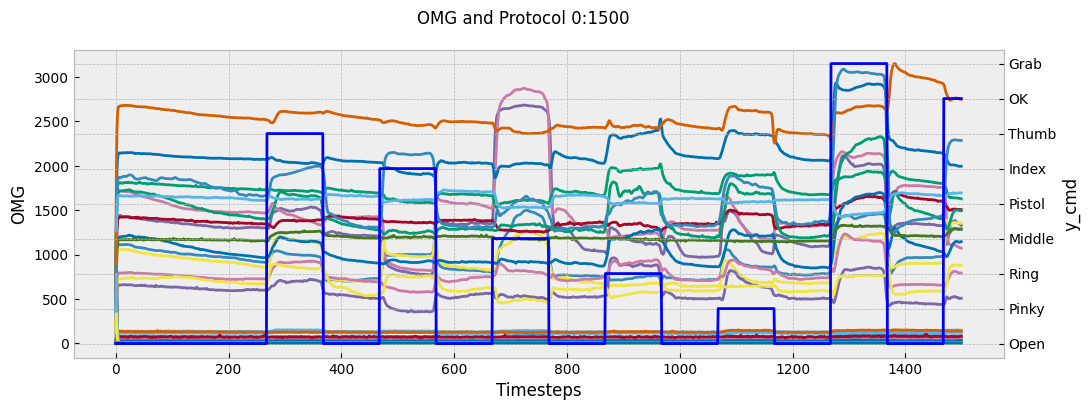

In [32]:
X_train_ax_ar_ce_ = get_convolve(X_train_ax_ar_, M=10, tau=1, sym=False)
X_valid_ax_ar_ce_ = get_convolve(X_valid_ax_ar_, M=10, tau=1, sym=False)

get_graphs(X_train_ax_ar_ce_, y_train_2d, start=0, end=1500)

#### Сглаживание с помощью метода из pandas

In [33]:
# Функция для экспоненциального сглаживания
def get_smoothing(Xdf, sample_size=5, alpha=0.5):
    """Функция для экспоненциального сглаживания

    Args:
        Xdf (ndarray): Массив данных.
        sample_size (int, optional): Размер сглаживаемой выборки. Defaults to 5.
        alpha (float, optional): Коэффициент сглаживания. Defaults to 0.3.

    Returns:
        ndarray: Преобразованный массив.
    """
    samples, j = [], 0
    for i in range(sample_size, Xdf.shape[0] + 1, sample_size):
        x_smoothed = Xdf.loc[j:i-1, list(Xdf.columns)].ewm(alpha=alpha, adjust=True).mean().values
        samples.append(x_smoothed)
        j = i
    
    X_ewm = np.row_stack(samples)
    
    return X_ewm

In [34]:
X_train_ax_ar_ewm_ = get_smoothing(pd.DataFrame(X_train_ax_ar_), sample_size=10, alpha=0.3)
X_valid_ax_ar_ewm_ = get_smoothing(pd.DataFrame(X_valid_ax_ar_), sample_size=10, alpha=0.3)

print(X_train_ax_ar_.shape, y_train_2d.shape)
print(X_valid_ax_ar_.shape, y_valid_2d.shape)
print(X_train_ax_ar_ewm_.shape, y_train_2d.shape)
print(X_valid_ax_ar_ewm_.shape, y_valid_2d.shape)

(25440, 290) (25440,)
(6860, 290) (6860,)
(25440, 290) (25440,)
(6860, 290) (6860,)


Порой после использования этой функции сглаживания выборки укорачиваются на несколько строк и не совпадают по длине с векторами целевых признаков. Код ниже написан для того, чтобы добавить в конец выборок нулевые строки в недостающем числе. 

In [35]:
diff1 = X_train_ax_ar_.shape[0] - X_train_ax_ar_ewm_.shape[0]
diff2 = X_valid_ax_ar_.shape[0] - X_valid_ax_ar_ewm_.shape[0]

zeros_array1 = np.zeros((diff1, X_train_ax_ar_.shape[1]))
zeros_array2 = np.zeros((diff2, X_valid_ax_ar_.shape[1]))

X_train_ax_ar_ewm_ = np.vstack((X_train_ax_ar_ewm_, zeros_array1))
X_valid_ax_ar_ewm_ = np.vstack((X_valid_ax_ar_ewm_, zeros_array2))

print(X_train_ax_ar_ewm_.shape, y_train_2d.shape)
print(X_valid_ax_ar_ewm_.shape, y_valid_2d.shape)

(25440, 290) (25440,)
(6860, 290) (6860,)


In [36]:
samples_dict_ewm = {}

for key in tqdm(samples_dict.keys(), desc="Processing"):
    train, valid = samples_dict[key]
    train_ewm = get_smoothing(pd.DataFrame(train), sample_size=10, alpha=0.3)
    valid_ewm = get_smoothing(pd.DataFrame(valid), sample_size=10, alpha=0.3)
    diff1 = train.shape[0] - train_ewm.shape[0]
    diff2 = valid.shape[0] - valid_ewm.shape[0]
    zeros_array1 = np.zeros((diff1, train.shape[1]))
    zeros_array2 = np.zeros((diff2, valid.shape[1]))
    train_ewm = np.vstack((train_ewm, zeros_array1))
    valid_ewm = np.vstack((valid_ewm, zeros_array2))
    key_ewm = f'ewm_{key}'
    samples_dict_ewm[key_ewm] = [train_ewm, valid_ewm]
    

# Объединяем словари
samples_dict.update(samples_dict_ce)
samples_dict.update(samples_dict_ewm)

Processing: 100%|██████████| 35/35 [00:59<00:00,  1.69s/it]


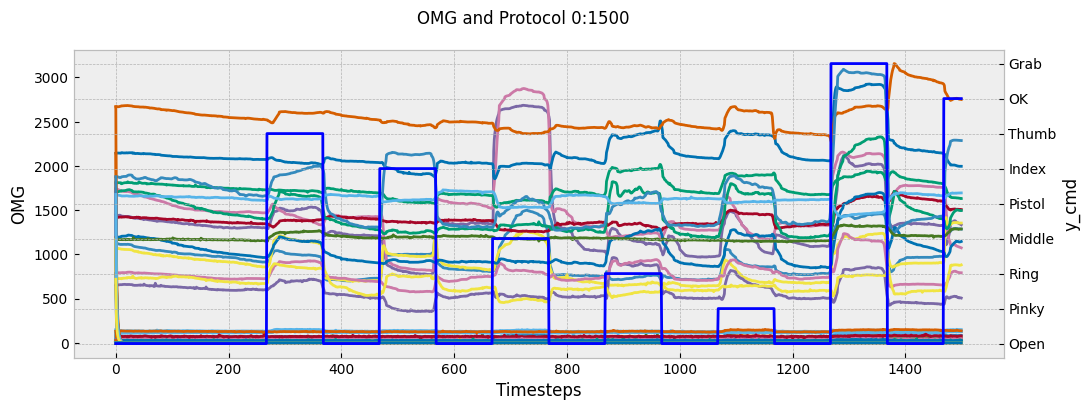

In [37]:
get_graphs(X_train_ax_ar_ewm_, y_train_2d, start=0, end=1500)

### Отбор признаков

#### Понижение размерности

In [38]:
i = 0 # изменить индекс чтобы выбрать сэмпл
X_train_exp, X_valid_exp = samples_dict[list(samples_dict.keys())[i]]

# Включаем предупреждениe как исключениe
warnings.simplefilter('error', RuntimeWarning)

# Матрица корреляций
corr_mtrx = pd.DataFrame(data=X_train_exp).corr()

# Параметры матрицы
print('Число столбцов:', corr_mtrx.shape[1])

# Расчет ранга матрицы либо перехват исключения
try:
    matrix_rank = np.linalg.matrix_rank(corr_mtrx)
except Exception as e:
    print('Ошибка:', e)
else:
    print('Ранг матрицы:  ', np.linalg.matrix_rank(corr_mtrx))
    
# Расчет определителя либо перехват предупреждения
try:
    det = np.linalg.det(corr_mtrx)
except RuntimeWarning as rw:
    print(f"""Ошибка вычисления определителя: {rw}
Матрица корреляций является вырожденной""")
else:
    print('Определитель:  ', np.linalg.det(corr_mtrx))

Число столбцов: 40
Ранг матрицы:   40
Определитель:   1.821068060623738e-25


Имеется мультколлинеарность, попробуем уменьшить размерность данных.

In [39]:
# Определяем метод таким образом, чтобы отобранные им
# компоненты объясняли не менее 99,99 % разброса данных
pca = decomposition.PCA(n_components=0.9999, random_state=42).fit(X_train_exp)
# Обучаем алгоритм на наших данных
print(f'Число компонент: {len(pca.components_)}')

Число компонент: 28


In [40]:
X_train_pca = pca.transform(X_train_exp)
X_valid_pca = pca.transform(X_valid_exp)
# Матрица корреляций
corr_mtrx = np.corrcoef(X_train_pca.transpose())

# Параметры матрицы
print('Число столбцов:', corr_mtrx.shape[1])
print('Ранг матрицы:  ', np.linalg.matrix_rank(corr_mtrx))
print('Определитель:  ', np.linalg.det(corr_mtrx))

Число столбцов: 28
Ранг матрицы:   28
Определитель:   0.9999999999999989


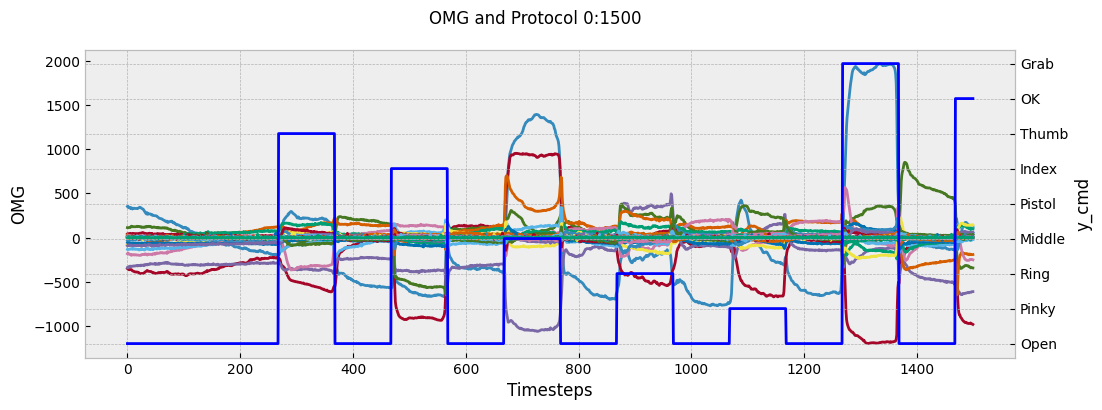

In [41]:
get_graphs(X_train_pca, y_train_2d, start=0, end=1500)

In [42]:
samples_dict_pca = {}

for key in tqdm(samples_dict.keys(), desc="Processing"):
    train, valid = samples_dict[key]
    pca = decomposition.PCA(n_components=0.9999, random_state=42).fit(train)
    train_pca = pca.transform(train)
    valid_pca = pca.transform(valid)
    key_pca = f'pca_{key}'
    samples_dict_pca[key_pca] = [train_pca, valid_pca]

# Объединяем словари
samples_dict.update(samples_dict_pca)

Processing: 100%|██████████| 105/105 [00:07<00:00, 13.57it/s]


---
---
## Моделирование

### Часть 1. Соревнование моделей на данных

Сперва нам нужно исследовать ряд алгоритмов с базовыми настройками "из коробки" (ну, или с некоторой минимальной настройкой гиперпараметров), чтобы определить наиболее перспективные из них — эти же в дальнешем мы будем использовать на инференсе, а также попробуем оптимизировать с помощью optuna.

Сперва соберем зоопарк алгоритмов:

In [43]:
# Наивный байесовксий классификатор
gnb = naive_bayes.GaussianNB()

# Линейная регрессия
lr = linear_model.LogisticRegression(
    solver='liblinear',
    max_iter=10000,
    random_state=42
)

# Пассивно-агрессивный классификатор
pac = linear_model.PassiveAggressiveClassifier(random_state=42)

# Простой перцептрон
pct = linear_model.Perceptron(random_state=42)

# Линейный классификатор на Тихоновской регуляризации
rc = linear_model.RidgeClassifier(random_state=42)

# Линейный классификатор на стохастическом градиентном спуске
sgdc = linear_model.SGDClassifier(random_state=42)

# Линейный классификатор на опорных векторах
lsvc = svm.LinearSVC(
    dual='auto',
    random_state=42,
    max_iter=2000
)

# Метод опорных векторов
svc = svm.SVC(random_state=42)

# Классификатор на k-ближайших соседях
knc = neighbors.KNeighborsClassifier()

# Многослойный перцептрон
mlpc = neural_network.MLPClassifier(
    max_iter=2000,
    random_state=42
)

# Дерево решений
dtc = tree.DecisionTreeClassifier(random_state=42)

# Классификатор адаптивного бустинга на деревьях решений
abc = ensemble.AdaBoostClassifier(
    estimator=tree.DecisionTreeClassifier(),
    algorithm='SAMME',
    random_state=42
)

# Простой бэггинг на деревьях решений
bc = ensemble.BaggingClassifier(
    estimator=tree.DecisionTreeClassifier(),
    n_jobs=-1,
    random_state=42
)

# Классификатор чрезвычайно рандомизированных деревьев
etc = ensemble.ExtraTreesClassifier(
    n_jobs=-1,
    random_state=42
)

# Градиентный бустинг
gbc = ensemble.GradientBoostingClassifier(random_state=42)

# Лес случайных деревьев
rfc = ensemble.RandomForestClassifier(
    n_jobs=-1,
    random_state=42
)

# Градиентный бустинг на гистограммах
hgbc = ensemble.HistGradientBoostingClassifier(random_state=42)

# Крутой градиентный бустинг :)
xgbc = xgb.XGBClassifier(seed=42, n_jobs=-1)

# Градиентный бустинг от Microsoft
lgbmc = lgbm.LGBMClassifier(
    objective='multiclass',
    seed=42
)

# Градиентный бустинг от Яндекс
cbc = cb.CatBoostClassifier(verbose=False, random_seed=42)

In [44]:
# Соберем их в один список
models = [
    gnb, lr, pac, pct, rc, sgdc, lsvc, svc, knc, mlpc, 
    dtc, abc, bc, etc, gbc, rfc, hgbc, xgbc, lgbmc, cbc
]

Для каждого вида предобобработки данных прогоним весь пул алгоритмов и сохраним результат (расчет f1-weighted) в единую таблицу.

In [45]:
# results = np.zeros((len(models), 0))

# progress_bar = tqdm(samples_dict.keys(), desc='Processing samples')
# for key in progress_bar:
#     train, valid = samples_dict[key]
#     f1_weighted = []

#     for model in models:
        
#         model.fit(train, y_train_2d[:train_ss])
#         preds_valid = model.predict(valid)
#         f1_weighted.append(metrics.f1_score(y_valid_2d[:valid_ss], preds_valid, average='weighted'))
        
#     f1_weighted_vec = np.array(f1_weighted).reshape(-1, 1)
#     results = np.hstack((results, f1_weighted_vec))

На прогон 20 алгоритмов по 210 парам экземпляров ушло почти 15 с половиной часов. Когда-нибудь в будущем мне придется хорошенько подумать над оптимизацией метода.

Второй минус данного метода в том, что обучение лишь на экземплярах данных не позволяет достичь максимальных значений метрик и установить таким образом самые оптимальные типы данных, но позволяет только с некоторой долей уверенности судить о таковых. Будем это иметь в виду.

Оформим теперь получившийся массив в виде датафрейма.

In [75]:
# columns = [
#     'GNB', 'LR', 'PAC', 'Pct', 'RC',
#     'SGDC', 'LSVC', 'SVC', 'KNC', 'MLPC',
#     'DTC', 'ABC', 'BC', 'ETC', 'GBC',
#     'RFC', 'HGBC', 'XGBC', 'LGBMC', 'CBC'
# ]

# results_df = pd.DataFrame(data=results.T, columns=columns)

# # Сохранение датафрейма в CSV файл
# results_df.to_csv('f1_weighted_results_massive.csv', index=False)

In [45]:
pd.set_option('display.max_rows', None)

# Если требуется подгрузить таблицу полученных ранее результатов 
results_df = pd.read_csv('derivatives/f1_weighted_results_massive.csv')

# Выведем часть разукрашенной таблицы
display(results_df[:20].style.background_gradient(
    cmap='coolwarm',
    vmin=results_df.min().min(), vmax=results_df.max().max(),
    subset=list(results_df.columns)
))

# Составим топ алгоритмов
i = 10
top_values = results_df.stack().nlargest(i)  # Получаем топ-i наибольших значений в датафрейме
for index, value in top_values.items():  # Перебираем полученные значения и их индексы
    row, col = index  # Получаем индекс строки и столбца
    print(f"Индекс: {row}".ljust(11), f"| Алгоритм: {col}".ljust(15), f"| Метрика: {round(value, 4)}")

,GNB,LR,PAC,Pct,RC,SGDC,LSVC,SVC,KNC,MLPC,DTC,ABC,BC,ETC,GBC,RFC,HGBC,XGBC,LGBMC,CBC
0,0.844909,0.712703,0.761831,0.768673,0.683610,0.743495,0.720067,0.871354,0.926702,0.758677,0.653626,0.648421,0.700082,0.870660,0.748111,0.828537,0.853817,0.878964,0.847075,0.888967
1,0.844909,0.846867,0.836462,0.825083,0.741578,0.850306,0.829055,0.885976,0.863253,0.729046,0.651928,0.648421,0.699233,0.870660,0.747666,0.829352,0.853817,0.878964,0.860068,0.888967
2,0.822753,0.745169,0.839326,0.711340,0.785615,0.821969,0.870283,0.897874,0.912510,0.878049,0.518719,0.593994,0.708549,0.870720,0.753061,0.839454,0.746820,0.800673,0.730940,0.867672
3,0.844909,0.853309,0.842169,0.829962,0.687820,0.734836,0.815498,0.871497,0.859896,0.789818,0.656301,0.647859,0.699769,0.870660,0.748224,0.829604,0.853817,0.878964,0.836957,0.888967
4,0.844909,0.851723,0.820018,0.820972,0.686095,0.717312,0.830081,0.868130,0.883081,0.797778,0.653553,0.648115,0.697409,0.870660,0.747740,0.826132,0.853817,0.878964,0.847019,0.888967
5,0.374212,0.370884,0.220867,0.300790,0.369973,0.374214,0.370745,0.367239,0.372056,0.373964,0.319242,0.335459,0.369001,0.375412,0.377225,0.378822,0.375885,0.376193,0.374470,0.373171
6,0.368857,0.366586,0.322371,0.303744,0.366516,0.369030,0.366516,0.366516,0.362156,0.374409,0.307845,0.358272,0.369213,0.366210,0.368214,0.369565,0.367835,0.368271,0.367077,0.365341
7,0.374878,0.371706,0.221781,0.161231,0.370540,0.375103,0.370813,0.367239,0.375607,0.378402,0.309810,0.352993,0.374222,0.376850,0.374995,0.379025,0.374117,0.377284,0.378155,0.372360
8,0.366530,0.366516,0.157455,0.263115,0.366516,0.363311,0.366516,0.366516,0.366417,0.366293,0.306278,0.339754,0.367208,0.366320,0.366220,0.367922,0.367547,0.367069,0.366200,0.367128
9,0.366504,0.366516,0.318372,0.246868,0.366516,0.365276,0.366516,0.366516,0.365850,0.366914,0.306859,0.340980,0.367348,0.366586,0.369062,0.368515,0.364766,0.363548,0.366242,0.365863


Индекс: 0   | Алгоритм: KNC | Метрика: 0.9267
Индекс: 20  | Алгоритм: KNC | Метрика: 0.9267
Индекс: 25  | Алгоритм: KNC | Метрика: 0.9267
Индекс: 30  | Алгоритм: KNC | Метрика: 0.9267
Индекс: 105 | Алгоритм: KNC | Метрика: 0.9267
Индекс: 125 | Алгоритм: KNC | Метрика: 0.9267
Индекс: 130 | Алгоритм: KNC | Метрика: 0.9267
Индекс: 135 | Алгоритм: KNC | Метрика: 0.9267
Индекс: 105 | Алгоритм: SVC | Метрика: 0.9235
Индекс: 125 | Алгоритм: SVC | Метрика: 0.9235


Мы обучили 20 алгоритмов на экземплярах данных, и, как видим, метод k-ближайших соседей и метод опорных векторов быстрее прочих способны ухватить закономерности: они быстрее насыщаются, им нужно меньше данных.

Составим схему для расшифровки значений индексов, чтобы определить тип предобработки.

|idx|dfntn|idx|dfntn|idx|dfntn|idx|dfntn|idx|dfntn|idx|dfntn|idx|dfntn|
|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
|`0`|исходные данные|`5`|ax из `0`|`10`|ar из `0`|`15`|`5` + `10`|`20`|`0` + `5`|`25`|`0` + `10`|`30`|`0` + `5` + `10`|
|`1`|mm-данные|`6`|ax из `1`|`11`|ar из `1`|`16`|`6` + `11`|`21`|`1` + `6`|`26`|`1` + `11`|`31`|`1` + `6` + `11`|
|`2`|norm-данные|`7`|ax из `2`|`12`|ar из `2`|`17`|`7` + `12`|`22`|`2` + `7`|`27`|`2` + `12`|`32`|`2` + `7` + `12`|
|`3`|rb-данные|`8`|ax из `3`|`13`|ar из `3`|`18`|`8` + `13`|`23`|`3` + `8`|`28`|`3` + `13`|`33`|`3` + `8` + `13`|
|`4`|st-данные|`9`|ax из `4`|`14`|ar из `4`|`19`|`9` + `14`|`24`|`4` + `9`|`29`|`4` + `14`|`34`|`4` + `9` + `14`|


- Индексы `35-69` соответствуют тем же комбинациям + сглаживание CE.
- Индексы `70-104` соответствуют тем же комбинациям + сглаживание EWM.
- Индексы `105-209` соответствуют тем же комбинациям (105-139: без сглаживаний; 140-174 c CE; 175-209 c EWM) + PCA.

Далее можно пробовать оптимизировать эти алгоритмы с соответствующими наборами данных.

### Часть 2. Настройка моделей

Напишем тройку полезных функций.

In [46]:
def get_model_report(model, train_X, train_y, valid_X, valid_y):
    """Функция для получения отчета по модели.

    Args:
        model (abc.ABCMeta): алгоритм МО.
        train_X (ndarray): треннировочная выборка
        train_y (ndarray): вектор целевого признака трейн-выборки
        valid_X (ndarray): валидационная выборка
        valid_y (ndarray): вектор целевого признака валидационной выборки
        cv (bool): опция расчета кросс-валидации
    """
    # Обучение
    model.fit(train_X, train_y)
    # Предсказания
    preds_valid = model.predict(valid_X)
    # Вывод метрик
    report = metrics.classification_report(
        valid_y, preds_valid, target_names=GESTURES, digits=4
    )
    print("Classification Report:\n", report)
    

def get_idx_and_metrics(column, i=5):
    """Функция для получения индексов и метрик

    Args:
        column (str): название колонки
        i (int, optional): величина топа. Defaults to 5.
    """
    if column not in results_df.columns:
        print('Введен неверный псевдоним алгоритма')
    else:
        top_values = results_df[column].nlargest(i)  # Получаем топ-i наибольших значений в датафрейме
        for index, value in top_values.items():  # Перебираем полученные значения и их индексы
            row, col = index, value  # Получаем индекс строки и столбца
            print(f"Индекс: {row}".ljust(11), f"| Метрика: {round(value, 5)}")

---
### GaussianNB

In [47]:
# Выведем топ-5 для модели
get_idx_and_metrics('GNB', i=10)

Индекс: 26  | Метрика: 0.87744
Индекс: 31  | Метрика: 0.8771
Индекс: 16  | Метрика: 0.8626
Индекс: 11  | Метрика: 0.86226
Индекс: 66  | Метрика: 0.84878
Индекс: 61  | Метрика: 0.84839
Индекс: 20  | Метрика: 0.84604
Индекс: 21  | Метрика: 0.84586
Индекс: 23  | Метрика: 0.84512
Индекс: 24  | Метрика: 0.84494


26-й индекс ведет нас к данным, составленным из комбинации нормализованных исходных данных с помощью MinMax-метода и коэффициентов линейной регрессии (f1: 0.9004).

Однако беглая проверка других данных привела нас к (idx: 12) коэффициентам линейной регрессии от нормализованных данных (f1: 0.931). Хотя, как видим, 12-й индекс не вошел даже в топ-10. Это еще раз возвращает нас к замечанию о неоптимальности метода поиска лучшей комбинации модель-данные, когда она реализована на экземплярах, а не полных данных. 

Впрочем, мы могли бы организовать также поиск индивидуально по моделям для полных данных, что для GaussianNB, как для быстрого алгоритма, оптимальнее, но результаты, полученные уже с помощью реализованного метода, позволяют нам более не тратить времени.

#### Baseline

In [48]:
%%time
# Инициализация объекта
gnb = naive_bayes.GaussianNB()

# Получить отчет по модели
get_model_report(
    gnb,
    X_train_norm_ar, y_train_2d,
    X_valid_norm_ar, y_valid_2d
)

Classification Report:
               precision    recall  f1-score   support

        Open     0.9589    0.9447    0.9518      3728
       Pinky     0.9858    0.8675    0.9229       400
        Ring     0.9246    0.9500    0.9371       400
      Middle     0.9822    0.9675    0.9748       400
      Pistol     0.6152    0.8765    0.7230       332
       Index     0.7636    0.9450    0.8447       400
       Thumb     0.8771    0.9275    0.9016       400
          OK     1.0000    0.6550    0.7915       400
        Grab     0.9920    0.9350    0.9627       400

    accuracy                         0.9201      6860
   macro avg     0.8999    0.8965    0.8900      6860
weighted avg     0.9314    0.9201    0.9216      6860

CPU times: total: 172 ms
Wall time: 173 ms


#### Optimized

In [65]:
# # Определение функции для оптимизации
# def optuna_gnb(trial):
#     """Функция, обучающая модель GaussianNB по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     var_smoothing = trial.suggest_float('var_smoothing', 1e-10, 1e-1)
    
#     # Инициализация GaussianNB с оптимизируемыми гиперпараметрами
#     clf = naive_bayes.GaussianNB(
#         var_smoothing=var_smoothing
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_norm_ar, y_train_2d, cv=10, scoring="f1_weighted", n_jobs=-1
#     ).mean()

#     return score


# # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
# study_gnb = optuna.create_study(study_name="gnb_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=100, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update(1)
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_gnb.optimize(optuna_gnb, n_trials=100, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_gnb.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# gnb_opt = naive_bayes.GaussianNB(**study_gnb.best_params)
# # Получить отчет по модели
# get_model_report(
#     gnb_opt,
#     X_train_norm_ar, y_train_2d,
#     X_valid_norm_ar, y_valid_2d
# )

Optimizing: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s]


Лучшие гиперпараметры: {'var_smoothing': 0.00022251851151365847}
Classification Report:
               precision    recall  f1-score   support

        Open     0.9591    0.8364    0.8935      3728
       Pinky     0.9775    0.8675    0.9192       400
        Ring     0.9137    0.9525    0.9327       400
      Middle     0.9872    0.9650    0.9760       400
      Pistol     0.3121    0.8855    0.4615       332
       Index     0.7822    0.9425    0.8549       400
       Thumb     0.9453    0.9075    0.9260       400
          OK     1.0000    0.6775    0.8077       400
        Grab     0.9946    0.9125    0.9518       400

    accuracy                         0.8603      6860
   macro avg     0.8746    0.8830    0.8581      6860
weighted avg     0.9212    0.8603    0.8792      6860

------------------------------------------------------- 

           F1 valid cv-score:       0.881



В данном случае оптимизация на 100 трейлах несколько ограничила модель. Но в нашем случае гауссово-наивный байесовский метод и не являлся приоритетным алгоритмом.

---
### LogisticRegression

In [49]:
# Выведем топ-5 для модели
get_idx_and_metrics('LR')

Индекс: 133 | Метрика: 0.87717
Индекс: 138 | Метрика: 0.87443
Индекс: 204 | Метрика: 0.87391
Индекс: 168 | Метрика: 0.87292
Индекс: 16  | Метрика: 0.87277


133-й индекс ведет нас к данным, составленным из комбинации нормализованных Robust-методом исходных и коэффициентов линейной регрессии, пропущенной через понижение размерности PCA.

In [50]:
pca_lr = decomposition.PCA(n_components=0.9999, random_state=42).fit(X_train_rb_ar_)
pca_X_train_rb_ar_ = pca_lr.transform(X_train_rb_ar_)
pca_X_valid_rb_ar_ = pca_lr.transform(X_valid_rb_ar_)

#### Baseline

In [51]:
%%time
# Инициализируем объект LogisticRegression
lr = linear_model.LogisticRegression(
    solver='lbfgs',
    max_iter=3000,
    random_state=42
)

# Получить отчет по модели
get_model_report(
    lr, # алгоритм
    pca_X_train_rb_ar_, y_train_2d,
    pca_X_valid_rb_ar_, y_valid_2d
)

Classification Report:
               precision    recall  f1-score   support

        Open     0.9697    0.9874    0.9785      3728
       Pinky     0.9820    0.9525    0.9670       400
        Ring     0.9696    0.9575    0.9635       400
      Middle     0.9850    0.9875    0.9863       400
      Pistol     0.9902    0.9157    0.9515       332
       Index     0.9872    0.9625    0.9747       400
       Thumb     0.9505    0.9600    0.9552       400
          OK     0.9974    0.9525    0.9744       400
        Grab     0.9874    0.9800    0.9837       400

    accuracy                         0.9746      6860
   macro avg     0.9799    0.9617    0.9705      6860
weighted avg     0.9748    0.9746    0.9746      6860

CPU times: total: 5.36 s
Wall time: 887 ms


Неплохо. Конкретно это решение на платформе Kaggle для тестовой выборки имеет значения метрики:<br>

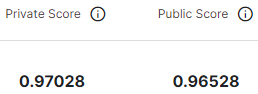

#### Optimized

In [67]:
# # Определение функции для оптимизации
# def optuna_lr(trial):
#     """Функция, обучающая модель LogisticRegression по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     C = trial.suggest_float('C', 1e-5, 1e2)
#     penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
    
#     if penalty == 'elasticnet':
#         l1_ratio = trial.suggest_float('l1_ratio', 0, 1)
#     else:
#         l1_ratio = None

#     solver = trial.suggest_categorical('solver', ['newton-cg', 'newton-cholesky', 'lbfgs', 'liblinear', 'saga'])

#     if penalty == 'l1' and solver in ['newton-cg', 'newton-cholesky', 'lbfgs', 'sag']:
#         return 0.0 # 'l1' penalty is not supported by these solvers
#     elif penalty == 'elasticnet' and solver not in ['saga']:
#         return 0.0 # 'elasticnet' penalty is supported only by 'saga' solver
    
#     # Инициализация LogisticRegression с оптимизируемыми гиперпараметрами
#     clf = linear_model.LogisticRegression(
#         C=C, penalty=penalty, solver=solver,
#         l1_ratio=l1_ratio, max_iter=10000,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, pca_X_train_rb_ar_, y_train_2d, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()

#     return score


# # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
# study_lr = optuna.create_study(study_name="lr_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=50, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update(1)
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_lr.optimize(optuna_lr, n_trials=50, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_lr.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# lr_opt = linear_model.LogisticRegression(
#     **study_lr.best_params,
#     max_iter=10000,
#     random_state=42
# )
# # Получить отчет по модели
# get_model_report(
#     lr_opt, # алгоритм
#     pca_X_train_rb_ar_, y_train_2d,
#     pca_X_valid_rb_ar_, y_valid_2d
# )

Optimizing: 100%|██████████| 50/50 [33:37<00:00, 40.35s/it]  


Лучшие гиперпараметры: {'C': 0.33418283522089387, 'penalty': 'l2', 'solver': 'newton-cholesky'}
Classification Report:
               precision    recall  f1-score   support

        Open     0.9640    0.9917    0.9777      3728
       Pinky     0.9921    0.9425    0.9667       400
        Ring     0.9845    0.9500    0.9669       400
      Middle     0.9875    0.9850    0.9862       400
      Pistol     0.9967    0.9127    0.9528       332
       Index     0.9897    0.9625    0.9759       400
       Thumb     0.9716    0.9425    0.9569       400
          OK     0.9922    0.9500    0.9706       400
        Grab     0.9848    0.9750    0.9799       400

    accuracy                         0.9742      6860
   macro avg     0.9848    0.9569    0.9704      6860
weighted avg     0.9746    0.9742    0.9741      6860

------------------------------------------------------- 

           F1 valid cv-score:       0.9701



Public score несколько повысился, а вот private сталь чуть ниже:

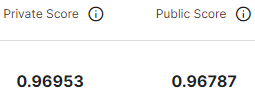

In [90]:
# Сохранение модели
# joblib.dump(lr_opt, "models/lr_opt.pkl")

['models/lr_opt.pkl']

---
### PassiveAggressiveClassifier

In [52]:
# Выведем топ-5 для модели
get_idx_and_metrics('PAC')

Индекс: 202 | Метрика: 0.88234
Индекс: 47  | Метрика: 0.88053
Индекс: 141 | Метрика: 0.88032
Индекс: 152 | Метрика: 0.87828
Индекс: 177 | Метрика: 0.87582


202-й индекс — это данные сглаженная на EWM и преобразованная в PCA комбинация нормализованных данных и коэффициентов линейной регрессии, полученных на них.

In [53]:
ewm_X_train_norm_ar_ = get_smoothing(pd.DataFrame(X_train_norm_ar_), sample_size=10, alpha=0.3)
ewm_X_valid_norm_ar_ = get_smoothing(pd.DataFrame(X_valid_norm_ar_), sample_size=10, alpha=0.3)

diff1 = X_train_norm_ar_.shape[0] - ewm_X_train_norm_ar_.shape[0]
diff2 = X_valid_norm_ar_.shape[0] - ewm_X_valid_norm_ar_.shape[0]

zeros_array1 = np.zeros((diff1, X_train_norm_ar_.shape[1]))
zeros_array2 = np.zeros((diff2, X_valid_norm_ar_.shape[1]))

ewm_X_train_norm_ar_ = np.vstack((ewm_X_train_norm_ar_, zeros_array1))
ewm_X_valid_norm_ar_ = np.vstack((ewm_X_valid_norm_ar_, zeros_array2))

pca_pac = decomposition.PCA(n_components=0.9999, random_state=42).fit(ewm_X_train_norm_ar_)
pca_ewm_X_train_norm_ar_ = pca_pac.transform(ewm_X_train_norm_ar_)
pca_ewm_X_valid_norm_ar_ = pca_pac.transform(ewm_X_valid_norm_ar_)

#### Baseline

In [54]:
%%time
pac = linear_model.PassiveAggressiveClassifier(random_state=42)

# Получить отчет по модели
get_model_report(
    pac, # алгоритм
    pca_ewm_X_train_norm_ar_, y_train_2d,
    pca_ewm_X_valid_norm_ar_, y_valid_2d
)

Classification Report:
               precision    recall  f1-score   support

        Open     0.9627    0.9911    0.9767      3728
       Pinky     0.9921    0.9425    0.9667       400
        Ring     0.9895    0.9425    0.9654       400
      Middle     0.9848    0.9750    0.9799       400
      Pistol     0.9935    0.9217    0.9563       332
       Index     0.9896    0.9550    0.9720       400
       Thumb     0.9496    0.9425    0.9460       400
          OK     1.0000    0.9450    0.9717       400
        Grab     0.9848    0.9750    0.9799       400

    accuracy                         0.9726      6860
   macro avg     0.9830    0.9545    0.9683      6860
weighted avg     0.9731    0.9726    0.9725      6860

CPU times: total: 406 ms
Wall time: 348 ms


#### Optimized

In [93]:
# # Определение функции для оптимизации
# def optuna_pac(trial):
#     """Функция, обучающая модель PassiveAggressive по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'C': trial.suggest_float('C', 1e-5, 1e5),
#         'max_iter': trial.suggest_int('max_iter', 100, 3000),
#         'early_stopping': True,
#         'n_jobs': -1
#     }

#     # Инициализация PassiveAggressive с оптимизируемыми гиперпараметрами
#     clf = linear_model.PassiveAggressiveClassifier(
#         **params,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, pca_ewm_X_train_norm_ar_, y_train_2d, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()

#     return score


# # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
# study_pac = optuna.create_study(study_name="pac_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=1000, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update(1)
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_pac.optimize(optuna_pac, n_trials=1000, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_pac.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# pac_opt = linear_model.PassiveAggressiveClassifier(
#     **study_pac.best_params,
#     random_state=42
# )
# # Получить отчет по модели
# get_model_report(
#     pac_opt, # алгоритм
#     pca_ewm_X_train_norm_ar_, y_train_2d,
#     pca_ewm_X_valid_norm_ar_, y_valid_2d
# )

Optimizing: 100%|██████████| 1000/1000 [08:47<00:00,  1.89it/s]


Лучшие гиперпараметры: {'C': 59816.56040695176, 'max_iter': 2623}
Classification Report:
               precision    recall  f1-score   support

        Open     0.9633    0.9928    0.9778      3728
       Pinky     0.9947    0.9450    0.9692       400
        Ring     0.9894    0.9350    0.9614       400
      Middle     0.9848    0.9750    0.9799       400
      Pistol     1.0000    0.9217    0.9592       332
       Index     0.9820    0.9550    0.9683       400
       Thumb     0.9272    0.9550    0.9409       400
          OK     1.0000    0.9150    0.9556       400
        Grab     0.9923    0.9700    0.9810       400

    accuracy                         0.9719      6860
   macro avg     0.9815    0.9516    0.9659      6860
weighted avg     0.9725    0.9719    0.9718      6860

------------------------------------------------------- 

           F1 valid cv-score:       0.9436



А в данном случае оптимизация даже на 1000 трейлов не смогла достичь уровня бейзлайна.

---
### Perceptron

In [55]:
# Выведем топ-5 для модели
get_idx_and_metrics('Pct')

Индекс: 16  | Метрика: 0.89165
Индекс: 192 | Метрика: 0.88155
Индекс: 141 | Метрика: 0.87803
Индекс: 106 | Метрика: 0.87451
Индекс: 51  | Метрика: 0.87153


Данные под 16 индексом состоят из комбинации исходных данных нормализованных MinMax-методом, коэффициентов линейной регрессии и авторегрессии, полученных на них.

#### Baseline

In [56]:
%%time
pct = linear_model.Perceptron(random_state=42)

# Получить отчет по модели
get_model_report(
    pct, # алгоритм
    X_train_mm_ax_ar_, y_train_2d,
    X_valid_mm_ax_ar_, y_valid_2d
)

Classification Report:
               precision    recall  f1-score   support

        Open     0.9560    0.9917    0.9735      3728
       Pinky     0.9971    0.8550    0.9206       400
        Ring     0.9973    0.9375    0.9665       400
      Middle     0.9825    0.9800    0.9812       400
      Pistol     0.9014    0.9367    0.9188       332
       Index     0.9974    0.9500    0.9731       400
       Thumb     0.9845    0.9500    0.9669       400
          OK     0.9898    0.9675    0.9785       400
        Grab     0.9946    0.9250    0.9585       400

    accuracy                         0.9671      6860
   macro avg     0.9778    0.9437    0.9597      6860
weighted avg     0.9680    0.9671    0.9668      6860

CPU times: total: 1.28 s
Wall time: 1.31 s


#### Optimized

In [101]:
# # Определение функции для оптимизации
# def optuna_pct(trial):
#     """Функция, обучающая модель Perceptron по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'penalty': trial.suggest_categorical('penalty', [None, 'l2', 'l1', 'elasticnet']),
#         'alpha': trial.suggest_float('alpha', 1e-5, 1e5),
#         'l1_ratio': trial.suggest_float('l1_ratio', 1e-5, 1),
#         'max_iter': trial.suggest_int('max_iter', 100, 3000),
#         'early_stopping': True,
#         'n_jobs': -1
#     }

#     # Инициализация Perceptron с оптимизируемыми гиперпараметрами
#     clf = linear_model.Perceptron(
#         **params,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_mm_ax_ar_, y_train_2d, cv=10, scoring="f1_weighted", n_jobs=-1
#     ).mean()

#     return score


# # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
# study_pct = optuna.create_study(study_name="pct_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=500, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update(1)
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_pct.optimize(optuna_pct, n_trials=500, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_pct.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# pct_opt = linear_model.Perceptron(
#     **study_pct.best_params,
#     random_state=42
# )
# # Получить отчет по модели
# get_model_report(
#     pct_opt, # алгоритм
#     X_train_mm_ax_ar_, y_train_2d,
#     X_valid_mm_ax_ar_, y_valid_2d
# )

Optimizing: 100%|██████████| 500/500 [15:59<00:00,  1.92s/it]


Лучшие гиперпараметры: {'penalty': None, 'alpha': 94295.21639991872, 'l1_ratio': 0.2564372369981552, 'max_iter': 1782}
Classification Report:
               precision    recall  f1-score   support

        Open     0.9560    0.9917    0.9735      3728
       Pinky     0.9971    0.8550    0.9206       400
        Ring     0.9973    0.9375    0.9665       400
      Middle     0.9825    0.9800    0.9812       400
      Pistol     0.9014    0.9367    0.9188       332
       Index     0.9974    0.9500    0.9731       400
       Thumb     0.9845    0.9500    0.9669       400
          OK     0.9898    0.9675    0.9785       400
        Grab     0.9946    0.9250    0.9585       400

    accuracy                         0.9671      6860
   macro avg     0.9778    0.9437    0.9597      6860
weighted avg     0.9680    0.9671    0.9668      6860

------------------------------------------------------- 

           F1 valid cv-score:       0.9561



Оптимизированная модель сошлась так, что повторила результат бейзлайна.

---
### RidgeClassifier

In [57]:
# Выведем топ-5 для модели
get_idx_and_metrics('RC')

Индекс: 151 | Метрика: 0.84595
Индекс: 46  | Метрика: 0.84594
Индекс: 51  | Метрика: 0.84131
Индекс: 156 | Метрика: 0.84076
Индекс: 81  | Метрика: 0.83766


Данные с индексом 151 получены понижением размерности сглаживанных методом CE коэффициентов авторегрессии, полученных на данных, нормализованных MinMax-методом.

In [58]:
ce_X_train_mm_ar = get_convolve(X_train_mm_ar, M=10, tau=1, sym=False)
ce_X_valid_mm_ar = get_convolve(X_valid_mm_ar, M=10, tau=1, sym=False)


pca_rc = decomposition.PCA(n_components=0.9999, random_state=42).fit(ce_X_train_mm_ar)
pca_ce_X_train_mm_ar = pca_rc.transform(ce_X_train_mm_ar)
pca_ce_X_valid_mm_ar = pca_rc.transform(ce_X_valid_mm_ar)

#### Baseline

In [59]:
%%time
rc = linear_model.RidgeClassifier(random_state=42)

# Получить отчет по модели
get_model_report(
    rc, # алгоритм
    pca_ce_X_train_mm_ar, y_train_2d,
    pca_ce_X_valid_mm_ar, y_valid_2d
)

Classification Report:
               precision    recall  f1-score   support

        Open     0.9451    0.9930    0.9685      3728
       Pinky     0.9918    0.9025    0.9450       400
        Ring     0.9894    0.9300    0.9588       400
      Middle     0.9798    0.9700    0.9749       400
      Pistol     0.9702    0.8825    0.9243       332
       Index     0.9819    0.9475    0.9644       400
       Thumb     0.9732    0.9075    0.9392       400
          OK     0.9920    0.9275    0.9587       400
        Grab     0.9946    0.9250    0.9585       400

    accuracy                         0.9620      6860
   macro avg     0.9798    0.9317    0.9547      6860
weighted avg     0.9630    0.9620    0.9617      6860

CPU times: total: 78.1 ms
Wall time: 85.7 ms


#### Optimized

In [106]:
# # Определение функции для оптимизации
# def optuna_rdg(trial):
#     """Функция, обучающая модель Ridge по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'alpha': trial.suggest_float('alpha', 1e-5, 1e-1),
#         'solver': trial.suggest_categorical('solver',
#             ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])
#     }
    
#     # Инициализация Ridge с оптимизируемыми гиперпараметрами
#     clf = linear_model.RidgeClassifier(
#         **params,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, pca_ce_X_train_mm_ar, y_train_2d, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()

#     return score


# # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
# study_rdg = optuna.create_study(study_name="rdg_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=50, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update(1)
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_rdg.optimize(optuna_rdg, n_trials=50, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_rdg.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# rc_opt = linear_model.RidgeClassifier(
#     **study_rdg.best_params,
#     random_state=42
# )
# # Получить отчет по модели
# get_model_report(
#     rc_opt, # алгоритм
#     pca_ce_X_train_mm_ar, y_train_2d,
#     pca_ce_X_valid_mm_ar, y_valid_2d
# )

Optimizing: 100%|██████████| 50/50 [08:05<00:00,  9.72s/it]


Лучшие гиперпараметры: {'alpha': 0.01550411826333236, 'solver': 'auto'}
Classification Report:
               precision    recall  f1-score   support

        Open     0.9551    0.9938    0.9741      3728
       Pinky     0.9867    0.9250    0.9548       400
        Ring     0.9947    0.9350    0.9639       400
      Middle     0.9848    0.9700    0.9773       400
      Pistol     0.9838    0.9157    0.9485       332
       Index     0.9819    0.9475    0.9644       400
       Thumb     0.9816    0.9325    0.9564       400
          OK     0.9816    0.9350    0.9577       400
        Grab     0.9921    0.9425    0.9667       400

    accuracy                         0.9685      6860
   macro avg     0.9825    0.9441    0.9627      6860
weighted avg     0.9692    0.9685    0.9683      6860

------------------------------------------------------- 

           F1 valid cv-score:       0.9651



Базовую модель удалось обойти.

---
### SGDClassifier

In [60]:
# Выведем топ-5 для модели
get_idx_and_metrics('SGDC')

Индекс: 46  | Метрика: 0.91078
Индекс: 51  | Метрика: 0.91057
Индекс: 186 | Метрика: 0.89186
Индекс: 151 | Метрика: 0.89164
Индекс: 156 | Метрика: 0.89107


46 — это 151-й без PCA. А его мы уже получили в прошлый раз. Однако F1 при нем был равен только 0.956. Если бегло проверить еще несколько типов данных, то можно набрести на комбинацию нормализованных MinMax-методом данных и коэффициентов авторегрессии, полученных на них. Этот тип данных выдает более высокий результат.

#### Baseline

In [61]:
%%time
# Инициализация объекта
sgdc = linear_model.SGDClassifier(random_state=42)
# Получить отчет по модели
get_model_report(
    sgdc, # алгоритм
    X_train_mm_ar_, y_train_2d,
    X_valid_mm_ar_, y_valid_2d
)

Classification Report:
               precision    recall  f1-score   support

        Open     0.9603    0.9925    0.9761      3728
       Pinky     0.9973    0.9150    0.9544       400
        Ring     0.9896    0.9500    0.9694       400
      Middle     0.9850    0.9825    0.9837       400
      Pistol     1.0000    0.9217    0.9592       332
       Index     0.9721    0.9575    0.9647       400
       Thumb     0.9667    0.9425    0.9544       400
          OK     1.0000    0.9350    0.9664       400
        Grab     0.9847    0.9675    0.9760       400

    accuracy                         0.9717      6860
   macro avg     0.9840    0.9516    0.9672      6860
weighted avg     0.9723    0.9717    0.9716      6860

CPU times: total: 734 ms
Wall time: 742 ms


Результат на Kaggle стал лучше.

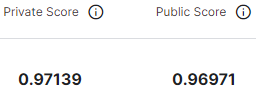

#### Optimized

In [121]:
# # Определение функции для оптимизации
# def optuna_sgdc(trial):
#     """Функция, обучающая модель SGD по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'loss': trial.suggest_categorical('loss',
#             ['hinge', 'log_loss', 'huber', 'modified_huber', 'squared_hinge', 'perceptron']),
#         'penalty': trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet']),
#         'alpha': trial.suggest_float('alpha', 1e-5, 1e-1),
#         'l1_ratio': trial.suggest_float('l1_ratio', 1e-5, 1),
#         'max_iter': trial.suggest_int('max_iter', 100, 1000),
#         'n_jobs': -1,
#         'early_stopping': True,
#     }
    
#     # Инициализация SGD с оптимизируемыми гиперпараметрами
#     clf = linear_model.SGDClassifier(
#         **params,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_mm_ar_, y_train_2d, cv=10, scoring="f1_weighted", n_jobs=-1
#     ).mean()

#     return score


# # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
# study_sgdc = optuna.create_study(study_name="sgdc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=200, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update(1)
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_sgdc.optimize(optuna_sgdc, n_trials=200, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_sgdc.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# sgdc_opt = linear_model.SGDClassifier(
#     **study_sgdc.best_params,
#     random_state=42
# )
# # Получить отчет по модели
# get_model_report(
#     sgdc_opt, # алгоритм
#     X_train_mm_ar_, y_train_2d,
#     X_valid_mm_ar_, y_valid_2d
# )

Optimizing: 100%|██████████| 200/200 [07:40<00:00,  2.30s/it]


Лучшие гиперпараметры: {'loss': 'log_loss', 'penalty': 'l1', 'alpha': 0.00015300166975045518, 'l1_ratio': 0.20736055377723628, 'max_iter': 678}
Classification Report:
               precision    recall  f1-score   support

        Open     0.9617    0.9901    0.9757      3728
       Pinky     1.0000    0.9050    0.9501       400
        Ring     0.9769    0.9525    0.9646       400
      Middle     0.9850    0.9825    0.9837       400
      Pistol     0.9934    0.9127    0.9513       332
       Index     0.9747    0.9625    0.9686       400
       Thumb     0.9314    0.9500    0.9406       400
          OK     1.0000    0.9250    0.9610       400
        Grab     0.9847    0.9675    0.9760       400

    accuracy                         0.9697      6860
   macro avg     0.9786    0.9497    0.9635      6860
weighted avg     0.9703    0.9697    0.9695      6860

------------------------------------------------------- 

           F1 valid cv-score:       0.9601



---
### LinearSVC

In [62]:
# Выведем топ-5 для модели
get_idx_and_metrics('LSVC')

Индекс: 116 | Метрика: 0.89276
Индекс: 151 | Метрика: 0.89258
Индекс: 46  | Метрика: 0.89121
Индекс: 172 | Метрика: 0.8911
Индекс: 121 | Метрика: 0.89086


116-й индекс принадлежит данным, плученным путем понижения размерности коэффициентов авторегрессии, полученных на данных, нормализованных MinMax-методом.

In [63]:
pca_lsvc = decomposition.PCA(n_components=0.9999, random_state=42).fit(X_train_mm_ar)
pca_X_train_mm_ar = pca_lsvc.transform(X_train_mm_ar)
pca_X_valid_mm_ar = pca_lsvc.transform(X_valid_mm_ar)

#### Baseline

In [64]:
%%time
# Инициализация объекта
lsvc = svm.LinearSVC(
    dual='auto',
    random_state=42,
    max_iter=2000
)
# Получить отчет по модели
get_model_report(
    lsvc, # алгоритм
    pca_X_train_mm_ar, y_train_2d,
    pca_X_valid_mm_ar, y_valid_2d
)

Classification Report:
               precision    recall  f1-score   support

        Open     0.9625    0.9922    0.9771      3728
       Pinky     0.9947    0.9300    0.9612       400
        Ring     0.9869    0.9450    0.9655       400
      Middle     0.9874    0.9800    0.9837       400
      Pistol     1.0000    0.9217    0.9592       332
       Index     0.9846    0.9600    0.9722       400
       Thumb     0.9595    0.9475    0.9535       400
          OK     1.0000    0.9500    0.9744       400
        Grab     0.9898    0.9700    0.9798       400

    accuracy                         0.9735      6860
   macro avg     0.9850    0.9552    0.9696      6860
weighted avg     0.9740    0.9735    0.9734      6860

CPU times: total: 2.39 s
Wall time: 2.39 s


#### Optimized

In [135]:
# # Определение функции для оптимизации
# def optuna_lsvc(trial):
#     """Функция, обучающая модель LinearSVC по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     penalty = trial.suggest_categorical('penalty', ['l2', 'l1'])
#     C = trial.suggest_float('C', 1e-5, 1e2)
#     multi_class = trial.suggest_categorical('multi_class', ['ovr', 'crammer_singer'])
    
#     if penalty == 'l1':
#         loss = 'squared_hinge'
#     else:
#         loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])

#     clf = svm.LinearSVC(
#         penalty=penalty, loss=loss, dual='auto',
#         C=C, multi_class=multi_class,
#         random_state=42, max_iter=10000
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, pca_X_train_mm_ar, y_train_2d, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()

#     return score


# # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
# study_lsvc = optuna.create_study(study_name="lsvc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=100, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update(1)
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_lsvc.optimize(optuna_lsvc, n_trials=100, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_lsvc.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# lsvc_opt = svm.LinearSVC(
#     **study_lsvc.best_params,
#     dual='auto',
#     random_state=42,
#     max_iter=10000
# )
# # Получить отчет по модели
# get_model_report(
#     lsvc_opt, # алгоритм
#     pca_X_train_mm_ar, y_train_2d,
#     pca_X_valid_mm_ar, y_valid_2d
# )

Вывод отчета в этом случае загрязнен предупреждениями о том, что функции оптимизации Liblinear не удалось сойтись и требуется увеличить количество итераций. F1 не удалось сильно повысить — 0.9598.

---
### SVC

In [65]:
# Выведем топ-5 для модели
get_idx_and_metrics('SVC')

Индекс: 105 | Метрика: 0.92347
Индекс: 125 | Метрика: 0.92347
Индекс: 130 | Метрика: 0.92343
Индекс: 135 | Метрика: 0.92343
Индекс: 175 | Метрика: 0.92182


105 — это исходные данные с PCA. А 125 — с коэффициентами линейной регрессии. 130 — с коэффициентами авторегрессии. В последнем случае результат чуть лучше.

In [66]:
pca_svc = decomposition.PCA(n_components=0.9999, random_state=42).fit(X_train_2d)
pca_X_train = pca_svc.transform(X_train_2d)
pca_X_valid = pca_svc.transform(X_valid_2d)

#------------------------------------------------------

pca_svc = decomposition.PCA(n_components=0.9999, random_state=42).fit(X_train_ar_)
pca_X_train_ar_ = pca_svc.transform(X_train_ar_)
pca_X_valid_ar_ = pca_svc.transform(X_valid_ar_)

#### Baseline

In [67]:
%%time
# Инициализация объекта
svc = svm.SVC(
    kernel='rbf',
    random_state=42
)
# Получить отчет по модели
get_model_report(
    svc, # алгоритм
    pca_X_train_ar_, y_train_2d,
    pca_X_valid_ar_, y_valid_2d
)

Classification Report:
               precision    recall  f1-score   support

        Open     0.9664    0.9938    0.9799      3728
       Pinky     0.9871    0.9600    0.9734       400
        Ring     0.9870    0.9525    0.9695       400
      Middle     0.9874    0.9825    0.9850       400
      Pistol     1.0000    0.9277    0.9625       332
       Index     0.9845    0.9525    0.9682       400
       Thumb     0.9846    0.9575    0.9708       400
          OK     0.9973    0.9350    0.9652       400
        Grab     0.9898    0.9750    0.9824       400

    accuracy                         0.9765      6860
   macro avg     0.9871    0.9596    0.9730      6860
weighted avg     0.9769    0.9765    0.9764      6860

CPU times: total: 16.9 s
Wall time: 16.9 s


Удалось еще улучшить результат на Kaggle:

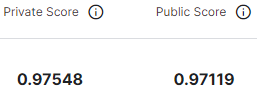

#### Optimized

In [157]:
# # Определение функции для оптимизации
# def optuna_svc(trial):
#     """Функция, обучающая модель SVC по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'C': trial.suggest_float('C', 1e-5, 1e2),
#         'degree': trial.suggest_int('degree', 0, 20)
#     }

#     clf = svm.SVC(
#         **params,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, pca_X_train_ar_, y_train_2d, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()

#     return score


# # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
# study_svc = optuna.create_study(study_name="svc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=200, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update(1)
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_svc.optimize(optuna_svc, n_trials=200, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_svc.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# svc_opt = svm.SVC(
#     **study_svc.best_params,
#     random_state=42
# )
# # Получить отчет по модели
# get_model_report(
#     svc_opt, # алгоритм
#     pca_X_train_ar_, y_train_2d,
#     pca_X_valid_ar_, y_valid_2d
# )

Optimizing: 100%|██████████| 200/200 [05:54<00:00,  1.77s/it]


Лучшие гиперпараметры: {'C': 0.8876324558730163, 'degree': 11}
Classification Report:
               precision    recall  f1-score   support

        Open     0.9659    0.9941    0.9798      3728
       Pinky     0.9897    0.9575    0.9733       400
        Ring     0.9896    0.9525    0.9707       400
      Middle     0.9874    0.9825    0.9850       400
      Pistol     1.0000    0.9277    0.9625       332
       Index     0.9845    0.9525    0.9682       400
       Thumb     0.9846    0.9575    0.9708       400
          OK     0.9973    0.9350    0.9652       400
        Grab     0.9898    0.9750    0.9824       400

    accuracy                         0.9765      6860
   macro avg     0.9876    0.9594    0.9731      6860
weighted avg     0.9770    0.9765    0.9764      6860

------------------------------------------------------- 

           F1 valid cv-score:       0.9697



На Kaggle результат, увы, лучше не стал.

---
### KNeighborsClassifier

In [68]:
# Выведем топ-5 для модели
get_idx_and_metrics('KNC')

Индекс: 0   | Метрика: 0.9267
Индекс: 20  | Метрика: 0.9267
Индекс: 25  | Метрика: 0.9267
Индекс: 30  | Метрика: 0.9267
Индекс: 105 | Метрика: 0.9267


#### Baseline

In [69]:
%%time
# Инициализация объекта
knc = neighbors.KNeighborsClassifier()
# Получить отчет по модели
get_model_report(
    knc, # алгоритм
    X_train_2d, y_train_2d,
    X_valid_2d, y_valid_2d
)

Classification Report:
               precision    recall  f1-score   support

        Open     0.9675    0.9887    0.9780      3728
       Pinky     0.9894    0.9350    0.9614       400
        Ring     0.9595    0.9475    0.9535       400
      Middle     0.9825    0.9800    0.9812       400
      Pistol     0.9903    0.9187    0.9531       332
       Index     0.9526    0.9550    0.9538       400
       Thumb     0.9696    0.9575    0.9635       400
          OK     0.9738    0.9300    0.9514       400
        Grab     0.9872    0.9675    0.9773       400

    accuracy                         0.9708      6860
   macro avg     0.9747    0.9533    0.9637      6860
weighted avg     0.9710    0.9708    0.9707      6860

CPU times: total: 1.23 s
Wall time: 260 ms


Интересный результат на кросс-валидации, на платформе ситуация иная:

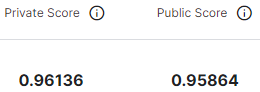

#### Optimized

In [183]:
# # Напишем функцию для оптимизации
# def optuna_knc(trial):
#     """Функция, обучающая модель KNeighborsClassifier по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'n_neighbors': trial.suggest_int('n_neighbors', 1, 30),
#         'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
#         'p': trial.suggest_int('p', 1, 2),
#         'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
#         'leaf_size': trial.suggest_int('leaf_size', 10, 50)
#     }

#     clf = neighbors.KNeighborsClassifier(**params)
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_2d, y_train_2d, cv=10, scoring="f1_weighted", n_jobs=-1
#     ).mean()

#     return score


# # Создание и запуск оптимизации с отображением прогресса с помощью tqdm
# study_knc = optuna.create_study(study_name="knc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=200, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update(1)
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_knc.optimize(optuna_knc, n_trials=200, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_knc.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# knc_opt = neighbors.KNeighborsClassifier(**study_knc.best_params)
# # Получить отчет по модели
# get_model_report(
#     knc_opt, # алгоритм
#     X_train_2d, y_train_2d,
#     X_valid_2d, y_valid_2d
# )

Optimizing: 100%|██████████| 200/200 [05:00<00:00,  1.50s/it]


Лучшие гиперпараметры: {'n_neighbors': 28, 'weights': 'uniform', 'p': 1, 'algorithm': 'brute', 'leaf_size': 47}
Classification Report:
               precision    recall  f1-score   support

        Open     0.9577    0.9962    0.9766      3728
       Pinky     0.9946    0.9175    0.9545       400
        Ring     0.9617    0.9425    0.9520       400
      Middle     0.9923    0.9700    0.9810       400
      Pistol     1.0000    0.9036    0.9494       332
       Index     0.9597    0.9525    0.9561       400
       Thumb     0.9739    0.9325    0.9527       400
          OK     1.0000    0.9125    0.9542       400
        Grab     0.9948    0.9575    0.9758       400

    accuracy                         0.9691      6860
   macro avg     0.9816    0.9428    0.9614      6860
weighted avg     0.9698    0.9691    0.9689      6860

------------------------------------------------------- 

           F1 valid cv-score:       0.9641



---
### MLPClassifier

In [70]:
# Выведем топ-5 для модели
get_idx_and_metrics('MLPC')

Индекс: 12  | Метрика: 0.90703
Индекс: 82  | Метрика: 0.90189
Индекс: 27  | Метрика: 0.89342
Индекс: 67  | Метрика: 0.89195
Индекс: 62  | Метрика: 0.89128


Под 12 индексом находятся коэффициенты авторегрессии на нормализованных данных.

#### Baseline

In [71]:
%%time
# Инициализация объекта
mlpc = neural_network.MLPClassifier(
    max_iter=2000,
    random_state=42
)
# Получить отчет по модели
get_model_report(
    mlpc, # алгоритм
    X_train_norm_ar, y_train_2d,
    X_valid_norm_ar, y_valid_2d
)

Classification Report:
               precision    recall  f1-score   support

        Open     0.9738    0.9866    0.9801      3728
       Pinky     0.9864    0.9050    0.9439       400
        Ring     0.9183    0.9550    0.9363       400
      Middle     0.9777    0.9850    0.9813       400
      Pistol     0.9968    0.9337    0.9642       332
       Index     0.9948    0.9575    0.9758       400
       Thumb     0.9282    0.9700    0.9487       400
          OK     0.9974    0.9600    0.9783       400
        Grab     0.9899    0.9850    0.9875       400

    accuracy                         0.9730      6860
   macro avg     0.9737    0.9598    0.9662      6860
weighted avg     0.9735    0.9730    0.9730      6860

CPU times: total: 27min 16s
Wall time: 4min 51s


А результат на платформе Kaggle, к сожалению, не столь впечатляющий:

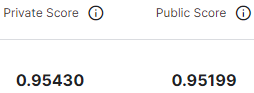

Видимо, модель переобучилась. Попробуем ее оптимизировать.

In [59]:
# Сохранение модели
# joblib.dump(mlpc, "models/mlpc.pkl")

['models/mlpc.pkl']

#### Optimized

In [61]:
# # Напишем функцию для оптимизации
# def optuna_mlp(trial):
#     """Функция, обучающая модель MLPClassifier по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'activation': trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu']),
#         'alpha': trial.suggest_float('alpha', 1e-5, 1e-2),
#         'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'adaptive'])
#     }
    
#     if trial.suggest_categorical('use_second_hidden_layer', [True, False]):
#         params['hidden_layer_sizes'] = (trial.suggest_int('n_units1', 1, 200),
#                                          trial.suggest_int('n_units2', 1, 200))
#     else:
#         params['hidden_layer_sizes'] = (trial.suggest_int('n_units1', 1, 200),)
    
#     # Инициализация MLPClassifier с оптимизируемыми гиперпараметрами
#     clf = neural_network.MLPClassifier(
#         **params,
#         max_iter=3000,
#         random_state=42
#     )

#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_norm_ar, y_train_2d, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()
    
#     return score


# # Создаем объект исследования для первого набора гиперпараметров
# # Укажем, что нам необходимо максимизировать метрику direction="maximize"
# study_mlp = optuna.create_study(study_name="mlp_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=50, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update()
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_mlp.optimize(optuna_mlp, n_trials=50, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_mlp.best_params)

# best_params = study_mlp.best_params
# n_units1 = best_params.pop('n_units1')
# flag = best_params.pop('use_second_hidden_layer')
# if flag:
#     n_units2 = best_params.pop('n_units2')
#     hidden_layer_sizes = (n_units1, n_units2)
# else:
#     hidden_layer_sizes = (n_units1,)

# # Передаем модели коллекцию оптимальных гиперпараметров
# mlpc_opt = neural_network.MLPClassifier(
#     hidden_layer_sizes=hidden_layer_sizes,
#     **best_params,
#     max_iter=3000,
#     random_state=42
# )
# # Получить отчет по модели
# get_model_report(
#     mlpc_opt, # алгоритм
#     X_train_norm_ar, y_train_2d,
#     X_valid_norm_ar, y_valid_2d
# )

[I 2024-03-28 13:42:10,187] A new study created in memory with name: mlp_opt
Optimizing: 100%|██████████| 50/50 [4:18:15<00:00, 309.90s/it]  


Лучшие гиперпараметры: {'activation': 'relu', 'alpha': 0.0025420975106657255, 'learning_rate': 'adaptive', 'use_second_hidden_layer': False, 'n_units1': 70}
Classification Report:
               precision    recall  f1-score   support

        Open     0.9706    0.9914    0.9809      3728
       Pinky     0.9921    0.9375    0.9640       400
        Ring     0.9502    0.9550    0.9526       400
      Middle     0.9874    0.9775    0.9824       400
      Pistol     1.0000    0.9277    0.9625       332
       Index     0.9897    0.9575    0.9733       400
       Thumb     0.9459    0.9625    0.9542       400
          OK     1.0000    0.9475    0.9730       400
        Grab     0.9924    0.9800    0.9862       400

    accuracy                         0.9754      6860
   macro avg     0.9809    0.9596    0.9699      6860
weighted avg     0.9757    0.9754    0.9753      6860

------------------------------------------------------- 

           F1 valid cv-score:       0.9688



In [62]:
# Сохранение модели
# joblib.dump(mlpc, "models/mlpc_opt.pkl")

['models/mlpc_opt.pkl']

Метрика, конечно, стала выше, но были модели и получше.

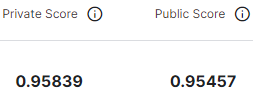

---
### DecisionTreeClassifier

In [72]:
# Выведем топ-5 для модели
get_idx_and_metrics('DTC')

Индекс: 25  | Метрика: 0.74438
Индекс: 33  | Метрика: 0.74038
Индекс: 30  | Метрика: 0.73535
Индекс: 100 | Метрика: 0.72611
Индекс: 45  | Метрика: 0.70622


#### Baseline

In [73]:
%%time
dtc = tree.DecisionTreeClassifier(random_state=42)
# Получить отчет по модели
get_model_report(
    dtc, # алгоритм
    X_train_ar_, y_train_2d,
    X_valid_ar_, y_valid_2d
)

Classification Report:
               precision    recall  f1-score   support

        Open     0.9337    0.9563    0.9449      3728
       Pinky     0.8898    0.7875    0.8355       400
        Ring     0.9620    0.9500    0.9560       400
      Middle     0.9379    0.9825    0.9597       400
      Pistol     0.8909    0.9096    0.9001       332
       Index     0.9246    0.9500    0.9371       400
       Thumb     0.9511    0.7300    0.8260       400
          OK     0.9048    0.9500    0.9268       400
        Grab     0.9698    0.9625    0.9661       400

    accuracy                         0.9318      6860
   macro avg     0.9294    0.9087    0.9169      6860
weighted avg     0.9319    0.9318    0.9306      6860

CPU times: total: 20.2 s
Wall time: 20.2 s


Оптимизация этого алгоритма проводилась за кулисами, и она ни к чему толковому, увы, ни привела: даже 200 трейлов не хватило для преодоления базовой модели.

---
### AdaBoostClassifier

In [74]:
# Выведем топ-5 для модели
get_idx_and_metrics('ABC')

Индекс: 30  | Метрика: 0.74052
Индекс: 65  | Метрика: 0.73888
Индекс: 100 | Метрика: 0.73833
Индекс: 25  | Метрика: 0.73696
Индекс: 95  | Метрика: 0.73196


30 — комбинация исходных данных с коэффициентами авторегрессии и лин. рег. Но получше оказался все же 25-й.

In [75]:
ce_X_train_ax_ar_ = get_smoothing(pd.DataFrame(X_train_ax_ar_), sample_size=10, alpha=0.3)
ce_X_valid_ax_ar_ = get_smoothing(pd.DataFrame(X_valid_ax_ar_), sample_size=10, alpha=0.3)

#### Baseline

In [76]:
%%time
abc = ensemble.AdaBoostClassifier(
    estimator=tree.DecisionTreeClassifier(),
    algorithm='SAMME',
    random_state=42
)
# Получить отчет по модели
get_model_report(
    abc, # алгоритм
    X_train_ar_, y_train_2d,
    X_valid_ar_, y_valid_2d
)

Classification Report:
               precision    recall  f1-score   support

        Open     0.9300    0.9557    0.9427      3728
       Pinky     0.8795    0.8025    0.8392       400
        Ring     0.9645    0.9500    0.9572       400
      Middle     0.9470    0.9825    0.9644       400
      Pistol     0.8736    0.9157    0.8941       332
       Index     0.9436    0.9625    0.9530       400
       Thumb     0.9435    0.6675    0.7818       400
          OK     0.9038    0.9400    0.9216       400
        Grab     0.9650    0.9650    0.9650       400

    accuracy                         0.9293      6860
   macro avg     0.9278    0.9046    0.9132      6860
weighted avg     0.9294    0.9293    0.9277      6860

CPU times: total: 21.2 s
Wall time: 21.3 s


Результат базовой модели не особенно впечатляет, а оптимизация несомненно займет довольно много времени, поэтому мы на этот раз пойдем дальше.

---
### BaggingClassifier

In [77]:
# Выведем топ-5 для модели
get_idx_and_metrics('BC')

Индекс: 95  | Метрика: 0.83488
Индекс: 103 | Метрика: 0.82029
Индекс: 60  | Метрика: 0.81325
Индекс: 100 | Метрика: 0.81126
Индекс: 98  | Метрика: 0.80736


95 индекс ведет к комбинации исходных данных с коэффициентами авторегрессии, сглаженной на EWM.

In [78]:
ewm_X_train_ar_ = get_smoothing(pd.DataFrame(X_train_ar_), sample_size=10, alpha=0.3)
ewm_X_valid_ar_ = get_smoothing(pd.DataFrame(X_valid_ar_), sample_size=10, alpha=0.3)

diff1 = X_train_ar_.shape[0] - ewm_X_train_ar_.shape[0]
diff2 = X_valid_ar_.shape[0] - ewm_X_valid_ar_.shape[0]

zeros_array1 = np.zeros((diff1, X_train_norm_ar_.shape[1]))
zeros_array2 = np.zeros((diff2, X_valid_norm_ar_.shape[1]))

ewm_X_train_ar_ = np.vstack((ewm_X_train_ar_, zeros_array1))
ewm_X_valid_ar_ = np.vstack((ewm_X_valid_ar_, zeros_array2))

#### Baseline

In [79]:
%%time
bc = ensemble.BaggingClassifier(
    estimator=tree.DecisionTreeClassifier(),
    n_jobs=-1,
    random_state=42
)
# Получить отчет по модели
get_model_report(
    abc, # алгоритм
    ewm_X_train_ar_, y_train_2d,
    ewm_X_valid_ar_, y_valid_2d
)

Classification Report:
               precision    recall  f1-score   support

        Open     0.9476    0.9555    0.9515      3728
       Pinky     0.8947    0.6375    0.7445       400
        Ring     0.8091    0.9325    0.8664       400
      Middle     0.9698    0.9650    0.9674       400
      Pistol     0.9286    0.9006    0.9144       332
       Index     0.9585    0.9250    0.9415       400
       Thumb     0.9481    0.9600    0.9540       400
          OK     0.8699    0.9525    0.9093       400
        Grab     0.9360    0.9500    0.9429       400

    accuracy                         0.9315      6860
   macro avg     0.9180    0.9087    0.9102      6860
weighted avg     0.9323    0.9315    0.9302      6860

CPU times: total: 18.2 s
Wall time: 18.2 s


---
### ExtraTreesClassifier

In [80]:
# Выведем топ-5 для модели
get_idx_and_metrics('ETC')

Индекс: 207 | Метрика: 0.91059
Индекс: 22  | Метрика: 0.90002
Индекс: 107 | Метрика: 0.89839
Индекс: 46  | Метрика: 0.89716
Индекс: 27  | Метрика: 0.89703


207-й индекс принадлежит сглаженной на EWM и прошедшей понижение размерности комбинации нормализованных данных и коэффициентов линейной и авторегресий.

In [81]:
ewm_X_train_norm_ax_ar_ = get_smoothing(pd.DataFrame(X_train_norm_ax_ar_), sample_size=10, alpha=0.3)
ewm_X_valid_norm_ax_ar_ = get_smoothing(pd.DataFrame(X_valid_norm_ax_ar_), sample_size=10, alpha=0.3)

diff1 = X_train_norm_ax_ar_.shape[0] - ewm_X_train_norm_ax_ar_.shape[0]
diff2 = X_valid_norm_ax_ar_.shape[0] - ewm_X_valid_norm_ax_ar_.shape[0]

zeros_array1 = np.zeros((diff1, X_train_norm_ax_ar_.shape[1]))
zeros_array2 = np.zeros((diff2, X_valid_norm_ax_ar_.shape[1]))

ewm_X_train_norm_ax_ar_ = np.vstack((ewm_X_train_norm_ax_ar_, zeros_array1))
ewm_X_valid_norm_ax_ar_ = np.vstack((ewm_X_valid_norm_ax_ar_, zeros_array2))

pca_etc = decomposition.PCA(n_components=0.9999, random_state=42).fit(ewm_X_train_norm_ax_ar_)
pca_ewm_X_train_norm_ax_ar_ = pca_etc.transform(ewm_X_train_norm_ax_ar_)
pca_ewm_X_valid_norm_ax_ar_ = pca_etc.transform(ewm_X_valid_norm_ax_ar_)

#### Baseline

In [82]:
%%time
etc = ensemble.ExtraTreesClassifier(
    n_jobs=-1,
    random_state=42
)
# Получить отчет по модели
get_model_report(
    etc, # алгоритм
    pca_ewm_X_train_norm_ax_ar_, y_train_2d,
    pca_ewm_X_valid_norm_ax_ar_, y_valid_2d
)

Classification Report:
               precision    recall  f1-score   support

        Open     0.9601    0.9949    0.9772      3728
       Pinky     0.9885    0.8575    0.9183       400
        Ring     0.9100    0.9350    0.9223       400
      Middle     0.9874    0.9800    0.9837       400
      Pistol     1.0000    0.9127    0.9543       332
       Index     0.9948    0.9575    0.9758       400
       Thumb     0.9896    0.9475    0.9681       400
          OK     1.0000    0.9500    0.9744       400
        Grab     0.9923    0.9700    0.9810       400

    accuracy                         0.9695      6860
   macro avg     0.9803    0.9450    0.9617      6860
weighted avg     0.9703    0.9695    0.9693      6860

CPU times: total: 1.97 s
Wall time: 247 ms


#### Optimized

In [90]:
# # Напишем функцию для оптимизации
# def optuna_etc(trial):
#     """Функция, обучающая модель ExtraTreesClassifier по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
#     }
    
#     # Инициализация ExtraTrees с оптимизируемыми гиперпараметрами
#     clf = ensemble.ExtraTreesClassifier(
#         **params,
#         n_jobs=-1,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, pca_ewm_X_train_norm_ax_ar_, y_train_2d, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()
    
#     return score


# # Создаем объект исследования для первого набора гиперпараметров
# # Укажем, что нам необходимо максимизировать метрику direction="maximize"
# study_etc = optuna.create_study(study_name="etc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=50, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update()
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_etc.optimize(optuna_etc, n_trials=50, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_etc.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# etc_opt = ensemble.ExtraTreesClassifier(
#     **study_etc.best_params,
#     n_jobs=-1,
#     random_state=42
# )
# # Получить отчет по модели
# get_model_report(
#     etc_opt, # алгоритм
#     pca_ewm_X_train_norm_ax_ar_, y_train_2d,
#     pca_ewm_X_valid_norm_ax_ar_, y_valid_2d
# )

Optimizing: 100%|██████████| 50/50 [04:14<00:00,  5.09s/it]


Лучшие гиперпараметры: {'n_estimators': 861, 'criterion': 'gini', 'min_samples_split': 9, 'min_samples_leaf': 2}
Classification Report:
               precision    recall  f1-score   support

        Open     0.9591    0.9949    0.9767      3728
       Pinky     0.9916    0.8850    0.9353       400
        Ring     0.9398    0.9375    0.9387       400
      Middle     0.9874    0.9800    0.9837       400
      Pistol     1.0000    0.9096    0.9527       332
       Index     0.9922    0.9550    0.9732       400
       Thumb     0.9894    0.9375    0.9628       400
          OK     1.0000    0.9475    0.9730       400
        Grab     0.9899    0.9775    0.9836       400

    accuracy                         0.9707      6860
   macro avg     0.9833    0.9472    0.9644      6860
weighted avg     0.9714    0.9707    0.9705      6860

------------------------------------------------------- 

           F1 valid cv-score:       0.9595



Хороший результат, но наилучший:

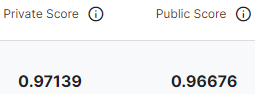

---
### GradientBoostingClassifier

In [83]:
# Выведем топ-5 для модели
get_idx_and_metrics('GBC')

Индекс: 26  | Метрика: 0.8805
Индекс: 31  | Метрика: 0.87928
Индекс: 30  | Метрика: 0.87765
Индекс: 25  | Метрика: 0.86385
Индекс: 11  | Метрика: 0.86038


#### Baseline

In [84]:
%%time
gbc = ensemble.GradientBoostingClassifier(random_state=42)
# Получить отчет по модели
get_model_report(
    gbc, # алгоритм
    X_train_mm_ax_ar_, y_train_2d,
    X_valid_mm_ax_ar_, y_valid_2d
)

Classification Report:
               precision    recall  f1-score   support

        Open     0.9576    0.9748    0.9661      3728
       Pinky     0.9913    0.8550    0.9181       400
        Ring     0.9720    0.9550    0.9634       400
      Middle     0.9701    0.9725    0.9713       400
      Pistol     0.9900    0.8946    0.9399       332
       Index     0.9598    0.9550    0.9574       400
       Thumb     0.8603    0.9700    0.9119       400
          OK     0.8535    0.8300    0.8416       400
        Grab     0.9923    0.9625    0.9772       400

    accuracy                         0.9520      6860
   macro avg     0.9496    0.9299    0.9385      6860
weighted avg     0.9531    0.9520    0.9519      6860

CPU times: total: 32min 15s
Wall time: 32min 16s


Градиентный бустинг, увы, очень долго обучается и оптимизация гиперпараметров для него заняла бы намного больше времени. Достигнутый нами на данный момент максимальный результат (0.975) уже можно засчитывать как готовое решение, и мы потому можем позволить себе не задерживаться подолгу на добыче сопоставимых результатов с помощью тяжелых алгоритмов.

---
### RandomForestClassifier

In [85]:
# Выведем топ-5 для модели
get_idx_and_metrics('RFC')

Индекс: 15  | Метрика: 0.901
Индекс: 57  | Метрика: 0.89887
Индекс: 207 | Метрика: 0.8917
Индекс: 157 | Метрика: 0.89026
Индекс: 65  | Метрика: 0.88631


15 — это комбинация кэффициентов регрессионных методов, полученных на исходных данных.

#### Baseline

In [86]:
%%time
rfc = ensemble.RandomForestClassifier(
    n_jobs=-1,
    random_state=42
)
# Получить отчет по модели
get_model_report(
    rfc, # алгоритм
    X_train_ax_ar_, y_train_2d,
    X_valid_ax_ar_, y_valid_2d
)

Classification Report:
               precision    recall  f1-score   support

        Open     0.9660    0.9917    0.9787      3728
       Pinky     0.9886    0.8650    0.9227       400
        Ring     0.9575    0.9575    0.9575       400
      Middle     0.9850    0.9875    0.9863       400
      Pistol     1.0000    0.9307    0.9641       332
       Index     0.9773    0.9675    0.9724       400
       Thumb     0.9899    0.9825    0.9862       400
          OK     0.9974    0.9625    0.9796       400
        Grab     0.9873    0.9725    0.9798       400

    accuracy                         0.9743      6860
   macro avg     0.9832    0.9575    0.9697      6860
weighted avg     0.9747    0.9743    0.9741      6860

CPU times: total: 1min 7s
Wall time: 6.28 s


Неплохо:

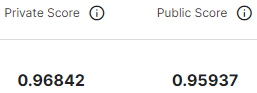

#### Optimized

In [117]:
# # Напишем функцию для оптимизации
# def optuna_rfc(trial):
#     """Функция, обучающая модель RandomForest по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 500),
#         'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
#         'max_depth': trial.suggest_int('max_depth', 3, 45),
#         'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
#     }
    
#     # Инициализация RandomForest с оптимизируемыми гиперпараметрами
#     clf = ensemble.RandomForestClassifier(
#         **params,
#         n_jobs=-1,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_ax_ar_, y_train_2d, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()
    
#     return score


# # Создаем объект исследования для первого набора гиперпараметров
# # Укажем, что нам необходимо максимизировать метрику direction="maximize"
# study_rfc = optuna.create_study(study_name="rfc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=50, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update()
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_rfc.optimize(optuna_rfc, n_trials=50, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_rfc.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# rfc_opt = ensemble.RandomForestClassifier(
#     **study_rfc.best_params,
#     n_jobs=-1,
#     random_state=42
# )
# get_model_report(
#     rfc_opt, # алгоритм
#     X_train_ax_ar_, y_train_2d,
#     X_valid_ax_ar_, y_valid_2d
# )

Optimizing: 100%|██████████| 50/50 [1:05:57<00:00, 79.15s/it]


Лучшие гиперпараметры: {'n_estimators': 175, 'criterion': 'entropy', 'max_depth': 45, 'min_samples_split': 5, 'min_samples_leaf': 1}
Classification Report:
               precision    recall  f1-score   support

        Open     0.9681    0.9936    0.9807      3728
       Pinky     0.9915    0.8750    0.9296       400
        Ring     0.9338    0.9525    0.9431       400
      Middle     0.9875    0.9850    0.9862       400
      Pistol     1.0000    0.9277    0.9625       332
       Index     0.9872    0.9650    0.9760       400
       Thumb     0.9923    0.9725    0.9823       400
          OK     0.9974    0.9725    0.9848       400
        Grab     0.9898    0.9725    0.9811       400

    accuracy                         0.9752      6860
   macro avg     0.9831    0.9574    0.9696      6860
weighted avg     0.9757    0.9752    0.9750      6860

------------------------------------------------------- 

           F1 valid cv-score:       0.9539



Public — выше, private — ниже.

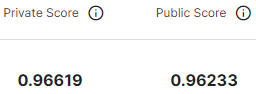

---
### HistGradientBoostingClassifier

In [87]:
# Выведем топ-5 для модели
get_idx_and_metrics('HGBC')

Индекс: 20  | Метрика: 0.88431
Индекс: 192 | Метрика: 0.87778
Индекс: 187 | Метрика: 0.87372
Индекс: 94  | Метрика: 0.87247
Индекс: 23  | Метрика: 0.87245


#### Baseline

In [88]:
%%time
hgbc = ensemble.HistGradientBoostingClassifier(random_state=42)
# Получить отчет по модели
get_model_report(
    hgbc, # алгоритм
    X_train_mm_ax_ar_, y_train_2d,
    X_valid_mm_ax_ar_, y_valid_2d
)

Classification Report:
               precision    recall  f1-score   support

        Open     0.9678    0.9922    0.9799      3728
       Pinky     0.9948    0.9575    0.9758       400
        Ring     0.9795    0.9550    0.9671       400
      Middle     0.9825    0.9800    0.9812       400
      Pistol     1.0000    0.9187    0.9576       332
       Index     0.9848    0.9700    0.9773       400
       Thumb     0.9897    0.9650    0.9772       400
          OK     0.9948    0.9575    0.9758       400
        Grab     0.9923    0.9675    0.9797       400

    accuracy                         0.9774      6860
   macro avg     0.9874    0.9626    0.9746      6860
weighted avg     0.9778    0.9774    0.9773      6860

CPU times: total: 1min 3s
Wall time: 11.3 s


Cобственно, результат на Kaggle:

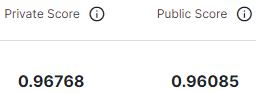

#### Optimized

In [60]:
# # Напишем функцию для оптимизации
# def optuna_hgbc(trial):
#     """Функция, обучающая модель HistGradientBoosting по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
#         'max_iter': trial.suggest_int('max_iter', 10, 300),
#         'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 50),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 30),
#         'l2_regularization': trial.suggest_float('l2_regularization', 0, 100) 
#     }
    
#     # Инициализация HistGradientBoosting с оптимизируемыми гиперпараметрами
#     clf = ensemble.HistGradientBoostingClassifier(
#         **params,
#         random_state=42
#     )
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_mm_ax_ar_, y_train_2d, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()
    
#     return score


# # Создаем объект исследования для первого набора гиперпараметров
# # Укажем, что нам необходимо максимизировать метрику direction="maximize"
# study_hgbc = optuna.create_study(study_name="hgbc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=50, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update()
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_hgbc.optimize(optuna_hgbc, n_trials=50, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_hgbc.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# hgbc_opt = ensemble.HistGradientBoostingClassifier(
#     **study_hgbc.best_params,
#     random_state=42
# )
# get_model_report(
#     hgbc_opt, # алгоритм
#     X_train_mm_ax_ar_, y_train_2d,
#     X_valid_mm_ax_ar_, y_valid_2d
# )

Немного возрос public score.

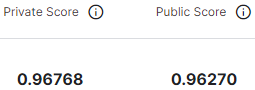

In [58]:
# Сохранение модели
# joblib.dump(hgbc_opt, "models/hgbc_opt.pkl")

['models/hgbc_opt.pkl']

---
### XGBClassifier

In [89]:
# Выведем топ-5 для модели
get_idx_and_metrics('XGBC')

Индекс: 26  | Метрика: 0.88222
Индекс: 21  | Метрика: 0.88006
Индекс: 0   | Метрика: 0.87896
Индекс: 1   | Метрика: 0.87896
Индекс: 3   | Метрика: 0.87896


#### Baseline

In [90]:
%%time
xgbc = xgb.XGBClassifier(seed=42, n_jobs=-1)
# Получить отчет по модели
get_model_report(
    xgbc, # алгоритм
    X_train_mm_ax_ar_, y_train_2d,
    X_valid_mm_ax_ar_, y_valid_2d
)

Classification Report:
               precision    recall  f1-score   support

        Open     0.9718    0.9909    0.9813      3728
       Pinky     0.9896    0.9475    0.9681       400
        Ring     0.9573    0.9525    0.9549       400
      Middle     0.9850    0.9875    0.9863       400
      Pistol     1.0000    0.9247    0.9609       332
       Index     0.9847    0.9650    0.9747       400
       Thumb     0.9798    0.9725    0.9762       400
          OK     0.9923    0.9650    0.9785       400
        Grab     0.9974    0.9775    0.9874       400

    accuracy                         0.9778      6860
   macro avg     0.9842    0.9648    0.9742      6860
weighted avg     0.9781    0.9778    0.9778      6860

CPU times: total: 1min 26s
Wall time: 7.82 s


Лучший private score:

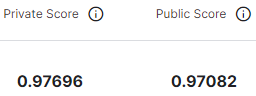

Полагаю, на этот раз можем обойтись без оптимизации гиперпараметров.

---
### LGBMClassifier

In [91]:
# Выведем топ-5 для модели
get_idx_and_metrics('LGBMC')

Индекс: 21  | Метрика: 0.8985
Индекс: 20  | Метрика: 0.87997
Индекс: 192 | Метрика: 0.87439
Индекс: 25  | Метрика: 0.86933
Индекс: 33  | Метрика: 0.867


#### Baseline

In [92]:
%%time
lgbmc = lgbm.LGBMClassifier(
    objective='multiclass',
    seed=42
)
# Получить отчет по модели
get_model_report(
    lgbmc, # алгоритм
    X_train_mm_ax_ar_, y_train_2d,
    X_valid_mm_ax_ar_, y_valid_2d
)

Classification Report:
               precision    recall  f1-score   support

        Open     0.9721    0.9917    0.9818      3728
       Pinky     0.9948    0.9625    0.9784       400
        Ring     0.9769    0.9525    0.9646       400
      Middle     0.9826    0.9900    0.9863       400
      Pistol     1.0000    0.9277    0.9625       332
       Index     0.9873    0.9725    0.9798       400
       Thumb     0.9898    0.9725    0.9811       400
          OK     0.9923    0.9725    0.9823       400
        Grab     0.9923    0.9675    0.9797       400

    accuracy                         0.9797      6860
   macro avg     0.9876    0.9677    0.9774      6860
weighted avg     0.9800    0.9797    0.9797      6860

CPU times: total: 1min 2s
Wall time: 5.74 s


Уже не впечатляет:

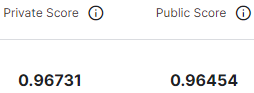

#### Optimized

In [47]:
# # Напишем функцию для оптимизации
# def optuna_lgbmc(trial):
#     """Функция, обучающая модель LGBM по переданным гиперпараметрам
#     Args:
#         trial : класс, от которого вызываются гиперпараметры
#     Returns:
#         score(float): метрика F1-weighted
#     """
#     # Задаем пространство поиска гиперпараметров
#     params = {
#         'objective': 'multiclass',
#         'metric': 'softmax',
#         'verbosity': -1,
#         'boosting_type': 'gbdt',
#         'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
#         'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 256),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1),
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
#         'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#     }

#     clf = lgbm.LGBMClassifier(**params, seed=42)
    
#     # Рассчитываем метрику на кросс-валидации
#     score = model_selection.cross_val_score(
#         clf, X_train_mm_ax_ar_, y_train_2d, cv=5, scoring="f1_weighted", n_jobs=-1
#     ).mean()
    
#     return score


# # Создаем объект исследования для первого набора гиперпараметров
# # Укажем, что нам необходимо максимизировать метрику direction="maximize"
# study_lgbmc = optuna.create_study(study_name="lgbmc_opt", direction='maximize')
# # Подавляем логирование
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Мониторим прогресс оптимизации
# with tqdm(total=50, desc="Optimizing") as pbar:
#     def update(study, trial):
#         pbar.update()
#     # Ищем лучшую комбинацию гиперпараметров n_trials раз
#     study_lgbmc.optimize(optuna_lgbmc, n_trials=50, callbacks=[update])

# # Получение оптимальных гиперпараметров
# print("Лучшие гиперпараметры:", study_lgbmc.best_params)

# # Передаем модели коллекцию оптимальных гиперпараметров
# lgbmc_opt = lgbm.LGBMClassifier(
#     **study_lgbmc.best_params,
#     seed=42
# )
# # Получить отчет по модели
# get_model_report(
#     lgbmc_opt, # алгоритм
#     X_train_mm_ax_ar_, y_train_2d,
#     X_valid_mm_ax_ar_, y_valid_2d
# )

[I 2024-03-29 14:48:11,779] A new study created in memory with name: lgbmc_opt
Optimizing: 100%|██████████| 50/50 [06:10<00:00,  7.40s/it]


Лучшие гиперпараметры: {'lambda_l1': 9.76733906560633, 'lambda_l2': 6.363511927214717, 'num_leaves': 155, 'learning_rate': 0.09815312644560548, 'feature_fraction': 0.433373332511895, 'bagging_fraction': 0.4117958803880425, 'bagging_freq': 2, 'min_child_samples': 82}
[LightGBM] [Warning] feature_fraction is set=0.433373332511895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.433373332511895
[LightGBM] [Warning] lambda_l1 is set=9.76733906560633, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.76733906560633
[LightGBM] [Warning] bagging_fraction is set=0.4117958803880425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4117958803880425
[LightGBM] [Warning] lambda_l2 is set=6.363511927214717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.363511927214717
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
Classification Report:
               precision    recall  f1-sco

In [48]:
# Сохранение модели
# joblib.dump(lgbmc_opt, "models/lgbmc_opt.pkl")

['models/lgbmc_opt.pkl']

Оптимизация чуть улучшила результат.

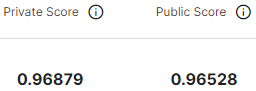

---
### CatBoostClassifier

In [93]:
# Выведем топ-5 для модели
get_idx_and_metrics('CBC')

Индекс: 157 | Метрика: 0.91899
Индекс: 192 | Метрика: 0.9101
Индекс: 127 | Метрика: 0.89794
Индекс: 207 | Метрика: 0.89496
Индекс: 0   | Метрика: 0.88897


#### Baseline

In [94]:
%%time
cbc = cb.CatBoostClassifier(verbose=False, random_seed=42)
# Получить отчет по модели
get_model_report(
    cbc, # алгоритм
    X_train_mm_ax_ar_, y_train_2d,
    X_valid_mm_ax_ar_, y_valid_2d
)

Classification Report:
               precision    recall  f1-score   support

        Open     0.9716    0.9917    0.9815      3728
       Pinky     0.9840    0.9250    0.9536       400
        Ring     0.9573    0.9525    0.9549       400
      Middle     0.9850    0.9875    0.9863       400
      Pistol     1.0000    0.9247    0.9609       332
       Index     0.9848    0.9725    0.9786       400
       Thumb     0.9899    0.9775    0.9836       400
          OK     0.9923    0.9675    0.9797       400
        Grab     0.9924    0.9750    0.9836       400

    accuracy                         0.9777      6860
   macro avg     0.9841    0.9638    0.9736      6860
weighted avg     0.9779    0.9777    0.9776      6860

CPU times: total: 23min 49s
Wall time: 2min 11s


Теперь впечатляет:

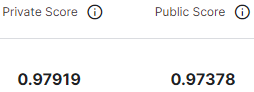

Ну, это занавес. Зачем ждать час-два оптимизации, чтобы улучшить результат на 0.5-1%, когда F1 уже почти 98?

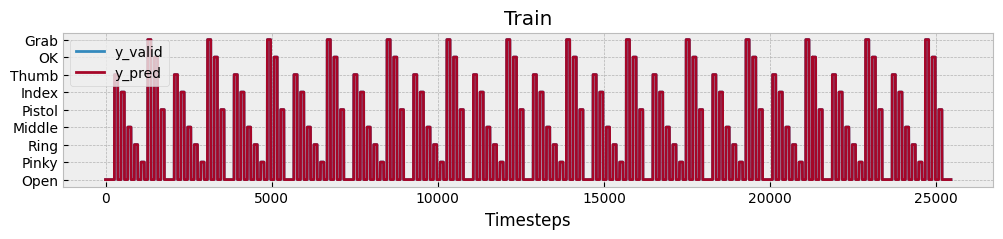

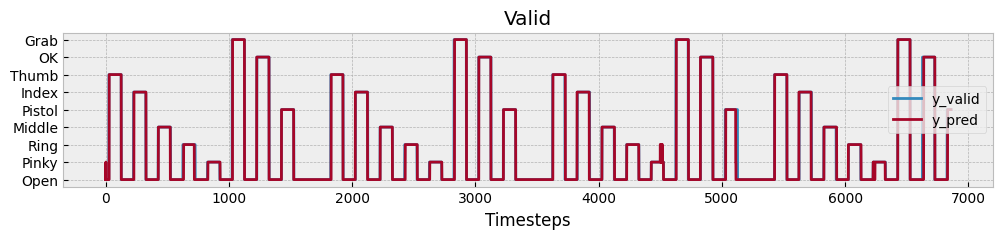

In [104]:
train_preds = cbc.predict(X_train_mm_ax_ar_)
valid_preds = cbc.predict(X_valid_mm_ax_ar_)

for i in range(2):
    plt.figure(figsize=(12, 2))
    if i == 0:
        true, preds, title = y_train_2d, train_preds, 'Train'
    else:
        true, preds, title = y_valid_2d, valid_preds, 'Valid'
    plt.plot(true, label='y_valid')
    plt.plot(preds, label='y_pred')
    plt.yticks(np.arange(len(GESTURES)), GESTURES)
    plt.grid(visible=True)
    plt.xlabel('Timesteps')
    plt.legend()
    plt.title(title)

Как видим, предсказания модели практически совпадают с таргетом на валидационной выборке.

---
---
## Предсказание на тестовой выборке

Сперва преобразуем тестовую выборку.

In [74]:
# pca_X_test_rb_ar_ = pca_lr.transform(X_test_rb_ar_)
#----------------------------------------------------
# pca_X_test_ar_ = pca_svc.transform(X_test_ar_)
#----------------------------------------------------
# ewm_X_test_norm_ax_ar_ = get_smoothing(pd.DataFrame(X_test_norm_ax_ar_), sample_size=10, alpha=0.3)
# diff = X_test_norm_ax_ar_.shape[0] - ewm_X_test_norm_ax_ar_.shape[0]
# zeros_array = np.zeros((diff, X_test_norm_ax_ar_.shape[1]))
# ewm_X_test_norm_ax_ar_ = np.vstack((ewm_X_test_norm_ax_ar_, zeros_array))

# pca_ewm_X_test_norm_ax_ar_ = pca_etc.transform(ewm_X_test_norm_ax_ar_)

In [96]:
# Предсказание загружаемой модели
# model = joblib.load("models/mlpc.pkl")
# y_pred = model.predict(X_test_norm_ar)

# сделаем предсказание классов на тестовой выборке
y_pred = cbc.predict(X_test_mm_ax_ar_)

### Подготовка данных для сабмита на Kaggle

In [97]:
y_test_preds = []
for idx, arr in zip(y_test.index, y_pred):
    series = pd.Series(arr)
    series.index = [f"{idx}-{i}" for i in series.index]
    y_test_preds.append(series)

y_test_preds = pd.concat(y_test_preds)
y_test_preds = y_test_preds.reset_index()
y_test_preds.columns = ["sample-timestep", "class"]
y_test_preds['sample-timestep'] = y_test['sample-timestep']
y_test_preds.head()

,sample-timestep,class
0,323-0,0
1,323-1,0
2,323-2,0
3,323-3,4
4,323-4,4


А еще можем посмотреть на распределение классов.

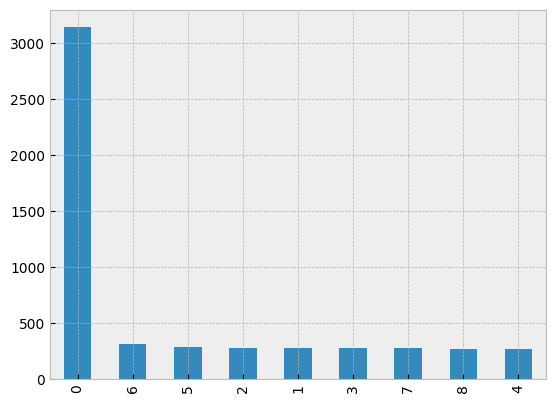

In [98]:
y_test_preds['class'].value_counts().plot(kind="bar");

Что ж, выглядит знакомо.

In [99]:
# Сохраним результат для отправки на платформу Kaggle
y_test_preds.to_csv('submitions/cbc_test_preds.csv', index=False)

### Визуализация результата моделирования

In [100]:
# подготовим данные
y_test_preds[['sample_id', 'timestep']] = y_test_preds['sample-timestep'].str.split(pat='-', n=1, expand=True).astype(int)
y_test_preds = y_test_preds.pivot(index='sample_id', columns='timestep', values='class')
y_test_index = y_test.index
y_test_preds = y_test_preds.sort_index() # на всякий случай
y_test_preds = y_test_preds.values

Здесь мы повторим код из начала тетрадки, чтобы также иметь возможность *пролистывать* тестовую выборку и смотреть на предсказания модели.

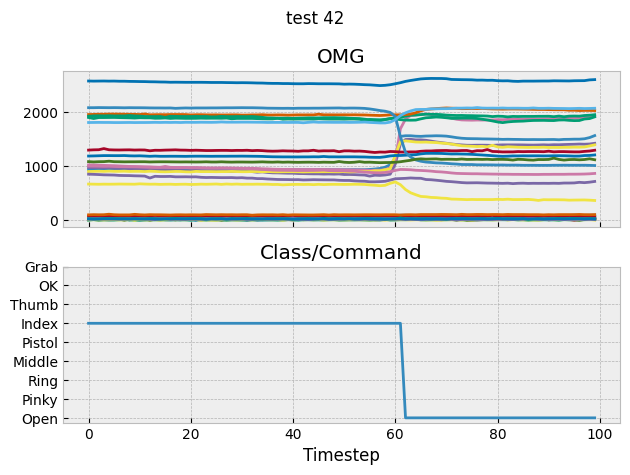

In [101]:
i = 42

fig, axx = plt.subplots(2, 1, sharex=True)
axx[0].plot(X_test[i].T)
axx[0].set_title('OMG')
axx[1].plot(y_test_preds[i])
axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'test {i}')
plt.tight_layout()

Или сразу выведем панорамный вид.

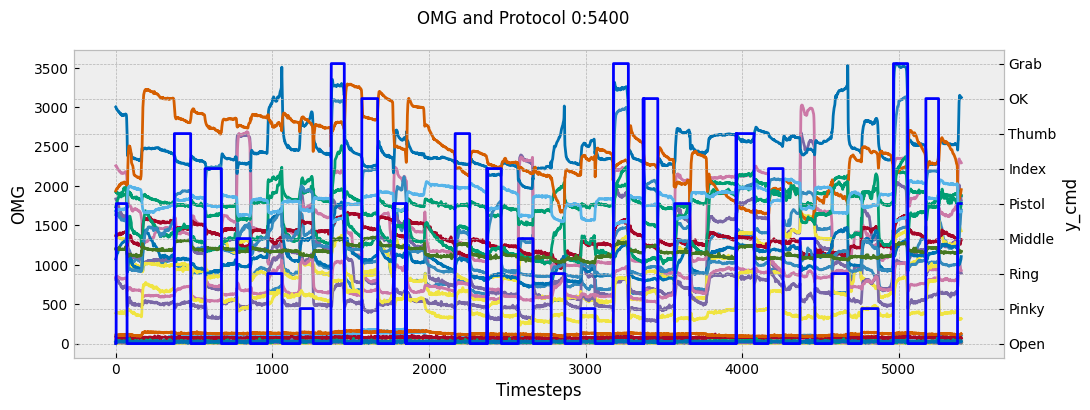

In [102]:
y_test_2d = y_test_preds.reshape(-1,)

get_graphs(X_test_2d, y_test_2d, start=0, end=X_test_2d.shape[0])

---
---
## Вывод

Удалось сносным образом решить задачу классификации временных рядов. Использование методов генерации признакового описания с помощью регрессионных моделей себя здорово оправдало: даже такой относително несложный инструмент, как логистическая регрессия, смог показать себя лучше, чем решение победителя конкурса. Но и обычное выравнивание таргета для трейн-части также помогло сэкономить много времени, избавив от необходимости изобретать новые способы манипуляций с данными, и вообще явилось весьма специфичным, простым и эффективным моментом решения: грубо говоря, моделям стало легче обучаться на данных.